# <font color='blue'>Modelo para classificação de uma ocorrência aeronáutica</font>
## <font color='blue'>Welington Nogueira</font>
### <font color='blue'>Objetivo: Propor modelos de machine learning capazes de classificar as ocorrências aeronáuticas com bases nos dados disponibilizados pelo CENIPA de ocorrências na aviação civil</font>

In [2]:
# Pacotes
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
import xgboost as xgb
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, roc_curve
import scipy.stats
import warnings
warnings.filterwarnings('ignore')

## Carregando os Dados

In [5]:
# Carregando os dados
df_aero = pd.read_csv("aeronave.csv")
df_oco = pd.read_csv("ocorrencia.csv")

In [7]:
# Shape aeronave
df_aero.shape

(2043, 22)

In [9]:
# Shape ocorrencia
df_oco.shape

(2027, 19)

In [11]:
# Visualizando alguns registros (aeronave)
df_aero.head()

,codigo_aeronave,codigo_ocorrencia,matricula,codigo_operador,equipamento,fabricante,modelo,tipo_motor,quantidade_motores,peso_maximo_decolagem,...,pais_registro,categoria_registro,categoria_aviacao,origem_voo,destino_voo,fase_operacao,tipo_operacao,nivel_dano,quantidade_fatalidades,dia_extracao
0,4,45602,PPGXE,241,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,56-C,PISTÃO,1.0,660,...,BRASIL,PRI,INSTRUÇÃO,SDPW,SDPW,INDETERMINADA,INSTRUÇÃO,SUBSTANCIAL,NaN,2016-07-30
1,40,53551,PPGSZ,160,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,56-C,PISTÃO,1.0,660,...,BRASIL,PRI,INSTRUÇÃO,SBBP,SBBP,DECOLAGEM,INSTRUÇÃO,LEVE,NaN,2016-07-30
2,118,43721,PTCMT,1232,AVIÃO,BEECH AIRCRAFT,95-B55,PISTÃO,2.0,2310,...,BRASIL,TPX,TÁXI AÉREO,****,****,CORRIDA APÓS POUSO,TÁXI AÉREO,SUBSTANCIAL,NaN,2016-07-30
3,130,35556,PTEQI,3992,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,EMB-721C,PISTÃO,1.0,1633,...,BRASIL,TPP,PARTICULAR,SNDU,SBSL,CORRIDA APÓS POUSO,PRIVADA,LEVE,NaN,2016-07-30
4,191,32579,PPVMM,4365,AVIÃO,BOEING COMPANY,737-241,JATO,2.0,52389,...,BRASIL,TPR,REGULAR,****,****,SUBIDA,REGULAR,NENHUM,NaN,2016-07-30


In [13]:
# Visualizando alguns registros (ocorrencia)
df_oco.head()

,codigo_ocorrencia,classificacao,tipo,localidade,uf,pais,aerodromo,dia_ocorrencia,horario,sera_investigada,comando_investigador,status_investigacao,numero_relatorio,relatorio_publicado,dia_publicacao,quantidade_recomendacoes,aeronaves_envolvidas,saida_pista,dia_extracao
0,47965,ACIDENTE,FALHA DO MOTOR EM VOO,ARIQUEMES,RO,BRASIL,SJOG,2013-05-05,11:00:00,***,SERIPA-7,NaN,NaN,NaN,NaN,0,1,NaN,2016-07-30
1,50313,INCIDENTE GRAVE,POUSO SEM TREM,CACOAL,RO,BRASIL,SSKW,2013-11-25,12:32:00,SIM,SERIPA-7,FINALIZADA,IG-209/CENIPA/2013,1.0,2014-04-07,0,1,NaN,2016-07-30
2,34078,ACIDENTE,PERDA DE CONTROLE NO SOLO,CEREJEIRAS,RO,BRASIL,****,2008-08-07,15:10:00,SIM,SERIPA-7,FINALIZADA,A - 517/CENIPA/2016,1.0,2016-07-07,0,1,1.0,2016-07-30
3,44988,ACIDENTE,POUSO LONGO,AMAJARI,RR,BRASIL,****,2011-08-11,17:00:00,SIM,SERIPA-7,FINALIZADA,A-105/CENIPA/2012,1.0,2012-09-20,4,1,NaN,2016-07-30
4,38855,ACIDENTE,PERDA DE CONTROLE EM VOO,ACEGUÁ,RS,BRASIL,****,2009-12-28,17:30:00,SIM,SERIPA-5,ATIVA,A DEFINIR,NaN,NaN,0,1,NaN,2016-07-30


In [15]:
# Info (ocorrencia)
df_oco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2027 entries, 0 to 2026
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   codigo_ocorrencia         2027 non-null   int64  
 1   classificacao             2027 non-null   object 
 2   tipo                      2027 non-null   object 
 3   localidade                2027 non-null   object 
 4   uf                        2027 non-null   object 
 5   pais                      2027 non-null   object 
 6   aerodromo                 2024 non-null   object 
 7   dia_ocorrencia            2027 non-null   object 
 8   horario                   2027 non-null   object 
 9   sera_investigada          2027 non-null   object 
 10  comando_investigador      2027 non-null   object 
 11  status_investigacao       1821 non-null   object 
 12  numero_relatorio          1821 non-null   object 
 13  relatorio_publicado       995 non-null    float64
 14  dia_publ

In [17]:
# Info (aeronave)
df_aero.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   codigo_aeronave         2043 non-null   int64  
 1   codigo_ocorrencia       2043 non-null   int64  
 2   matricula               2043 non-null   object 
 3   codigo_operador         2043 non-null   int64  
 4   equipamento             2043 non-null   object 
 5   fabricante              2043 non-null   object 
 6   modelo                  2043 non-null   object 
 7   tipo_motor              2043 non-null   object 
 8   quantidade_motores      2034 non-null   float64
 9   peso_maximo_decolagem   2043 non-null   int64  
 10  quantidade_assentos     2025 non-null   float64
 11  ano_fabricacao          2039 non-null   float64
 12  pais_registro           2043 non-null   object 
 13  categoria_registro      2043 non-null   object 
 14  categoria_aviacao       2043 non-null   

In [19]:
# Categorias da variável alvo
df_oco.classificacao.value_counts()

classificacao
ACIDENTE           1475
INCIDENTE GRAVE     552
Name: count, dtype: int64

In [21]:
from sklearn.preprocessing import LabelEncoder

# Cria o codificador
le = LabelEncoder()

# Aplica na coluna
df_oco["classificacao_cod"] = le.fit_transform(df_oco["classificacao"])

# Verifica o mapeamento
dict(zip(le.classes_, le.transform(le.classes_)))

{'ACIDENTE': 0, 'INCIDENTE GRAVE': 1}

In [23]:
# Resumo estatístico (variáveis numéricas) - ocorrencias
df_oco.describe()

,codigo_ocorrencia,relatorio_publicado,quantidade_recomendacoes,aeronaves_envolvidas,saida_pista,classificacao_cod
count,2027.000000,995.000000,2027.000000,2027.000000,256.000000,2027.000000
mean,43942.818451,0.993970,1.141095,1.007893,0.968750,0.272324
std,7863.305498,0.077458,3.571001,0.103906,0.174333,0.445265
min,25799.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,38839.500000,1.000000,0.000000,1.000000,1.000000,0.000000
50%,45554.000000,1.000000,0.000000,1.000000,1.000000,0.000000
75%,50347.500000,1.000000,1.000000,1.000000,1.000000,1.000000
max,65312.000000,1.000000,83.000000,4.000000,1.000000,1.000000


In [25]:
# Resumo estatístico (variáveis numéricas) - aeronaves
df_aero.describe()

,codigo_aeronave,codigo_ocorrencia,codigo_operador,quantidade_motores,peso_maximo_decolagem,quantidade_assentos,ano_fabricacao,quantidade_fatalidades
count,2043.000000,2043.000000,2043.000000,2034.000000,2043.00000,2025.000000,2039.000000,355.000000
mean,12300.670093,43961.869799,3156.447871,1.244346,5329.94420,8.928889,1902.494850,3.208451
std,7654.268691,7857.658738,1645.351104,0.483653,22004.50988,26.922299,402.024605,13.367108
min,4.000000,25799.000000,13.000000,0.000000,0.00000,0.000000,0.000000,1.000000
25%,9061.000000,38839.500000,1821.000000,1.000000,844.00000,2.000000,1975.000000,1.000000
50%,11267.000000,45564.000000,3992.000000,1.000000,1633.00000,4.000000,1986.000000,2.000000
75%,13601.500000,50353.500000,3992.000000,2.000000,2155.00000,6.000000,1999.000000,2.000000
max,39147.000000,65312.000000,6270.000000,4.000000,285990.00000,301.000000,2015.000000,199.000000


In [27]:
# Resumo estatístico (variáveis categóricas) - ocorrencias
df_oco.describe(include = ['object'])

,classificacao,tipo,localidade,uf,pais,aerodromo,dia_ocorrencia,horario,sera_investigada,comando_investigador,status_investigacao,numero_relatorio,dia_publicacao,dia_extracao
count,2027,2027,2027,2027,2027,2024,2027,2027,2027,2027,1821,1821,995,2027
unique,2,49,815,29,7,306,1510,437,3,9,3,1223,202,1
top,ACIDENTE,FALHA DO MOTOR EM VOO,RIO DE JANEIRO,SP,BRASIL,****,2012-09-24,20:30:00,SIM,SERIPA-4,FINALIZADA,A DEFINIR,2014-08-15,2016-07-30
freq,1475,377,64,434,2019,1217,6,54,1820,480,1059,433,25,2027


In [29]:
# Resumo estatístico (variáveis categóricas) - aeronaves
df_aero.describe(include = ['object'])

,matricula,equipamento,fabricante,modelo,tipo_motor,pais_registro,categoria_registro,categoria_aviacao,origem_voo,destino_voo,fase_operacao,tipo_operacao,nivel_dano,dia_extracao
count,2043,2043,2043,2043,2043,2043,2043,2043,2043,2043,2043,2043,2043,2043
unique,1871,8,120,515,6,16,24,13,393,392,24,10,5,1
top,PPGOB,AVIÃO,NEIVA INDUSTRIA AERONAUTICA,AB-115,PISTÃO,BRASIL,TPP,PARTICULAR,****,****,POUSO,PRIVADA,SUBSTANCIAL,2016-07-30
freq,4,1603,388,111,1601,2000,760,760,1110,1204,391,775,1193,2043


## Fazer um Join dos dois bancos (ocorrências e aeronaves)

In [32]:
# Garantir que é mesma chave em ambos df

df_oco["codigo_ocorrencia"] = df_oco["codigo_ocorrencia"].astype(int)
df_aero["codigo_ocorrencia"] = df_aero["codigo_ocorrencia"].astype(int)

In [34]:
# Gazer o merge mantendo todas as ocorrências, mesmo não tendo registro da aeronave (left)

df_join = pd.merge(df_oco, df_aero, on="codigo_ocorrencia", how="left")

In [36]:
df_join.head()

,codigo_ocorrencia,classificacao,tipo,localidade,uf,pais,aerodromo,dia_ocorrencia,horario,sera_investigada,...,pais_registro,categoria_registro,categoria_aviacao,origem_voo,destino_voo,fase_operacao,tipo_operacao,nivel_dano,quantidade_fatalidades,dia_extracao_y
0,47965,ACIDENTE,FALHA DO MOTOR EM VOO,ARIQUEMES,RO,BRASIL,SJOG,2013-05-05,11:00:00,***,...,BRASIL,PET,EXPERIMENTAL,****,****,CIRCUITO DE TRÁFEGO,EXPERIMENTAL,SUBSTANCIAL,NaN,2016-07-30
1,50313,INCIDENTE GRAVE,POUSO SEM TREM,CACOAL,RO,BRASIL,SSKW,2013-11-25,12:32:00,SIM,...,BRASIL,TPX,TÁXI AÉREO,SBJI,SSKW,POUSO,TÁXI AÉREO,SUBSTANCIAL,NaN,2016-07-30
2,34078,ACIDENTE,PERDA DE CONTROLE NO SOLO,CEREJEIRAS,RO,BRASIL,****,2008-08-07,15:10:00,SIM,...,BRASIL,TPX,TÁXI AÉREO,SWKK,SWRL,CORRIDA APÓS POUSO,TÁXI AÉREO,SUBSTANCIAL,NaN,2016-07-30
3,44988,ACIDENTE,POUSO LONGO,AMAJARI,RR,BRASIL,****,2011-08-11,17:00:00,SIM,...,BRASIL,TPX,TÁXI AÉREO,****,****,CORRIDA APÓS POUSO,TÁXI AÉREO,SUBSTANCIAL,NaN,2016-07-30
4,38855,ACIDENTE,PERDA DE CONTROLE EM VOO,ACEGUÁ,RS,BRASIL,****,2009-12-28,17:30:00,SIM,...,BRASIL,SAE,ESPECIALIZADA,****,****,DECOLAGEM,ESPECIALIZADA,SUBSTANCIAL,1.0,2016-07-30


In [40]:
# Verificar o shape
df_join.shape

(2043, 41)

In [42]:
# Verificar se há mais de uma ocorrência por matrícula
df_join["codigo_ocorrencia"].value_counts().head()

codigo_ocorrencia
38419    4
51433    2
45222    2
43869    2
30375    2
Name: count, dtype: int64

In [44]:
# Converter a variável-alvo (classificacao) para número
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_join["classificacao_cod"] = le.fit_transform(df_join["classificacao"])

# Mostrar o mapeamento
dict(zip(le.classes_, le.transform(le.classes_)))

{'ACIDENTE': 0, 'INCIDENTE GRAVE': 1}

In [46]:
# Calcular número e percentual de valores ausentes por variável
faltantes = df_join.isnull().sum()
percentuais = df_join.isnull().mean() * 100

# Cria um DataFrame só com as colunas que têm valores faltantes
df_na = pd.DataFrame({
    'Qtd_faltantes': faltantes,
    'Percentual_%': percentuais
})

# Filtra para mostrar apenas colunas com pelo menos 1 valor ausente
df_na = df_na[df_na['Qtd_faltantes'] > 0].sort_values(by='Percentual_%', ascending=False)

# Mostra o resultado
print(df_na)

                        Qtd_faltantes  Percentual_%
saida_pista                      1787     87.469408
quantidade_fatalidades           1688     82.623593
relatorio_publicado              1042     51.003426
dia_publicacao                   1042     51.003426
status_investigacao               209     10.230054
numero_relatorio                  209     10.230054
quantidade_assentos                18      0.881057
quantidade_motores                  9      0.440529
ano_fabricacao                      4      0.195791
aerodromo                           3      0.146843


In [48]:
# Remover colunas com mais de 10% de valores ausentes ou que não serão usadas
df_join_limpo = df_join.loc[:, percentuais <= 10]

print(f"Dimensão original: {df_join.shape}")
print(f"Dimensão após remoção: {df_join_limpo.shape}")

Dimensão original: (2043, 41)
Dimensão após remoção: (2043, 35)


In [50]:
# Categorias da variável alvo
df_join_limpo.classificacao_cod.value_counts()

classificacao_cod
0    1484
1     559
Name: count, dtype: int64

In [52]:
# Esta função calcula a prevalência de incidentes graves (label = 1)
def calcula_prevalencia(y_actual):
    return sum(y_actual) / len(y_actual)

print("Prevalência da classe positiva: %.3f"% calcula_prevalencia(df_join_limpo["classificacao_cod"].values))

Prevalência da classe positiva: 0.274


In [54]:
# nome das colunas
nomes_colunas = df_join_limpo.columns
nomes_colunas_lista = df_join_limpo.columns.tolist()
print(nomes_colunas_lista)

['codigo_ocorrencia', 'classificacao', 'tipo', 'localidade', 'uf', 'pais', 'aerodromo', 'dia_ocorrencia', 'horario', 'sera_investigada', 'comando_investigador', 'quantidade_recomendacoes', 'aeronaves_envolvidas', 'dia_extracao_x', 'classificacao_cod', 'codigo_aeronave', 'matricula', 'codigo_operador', 'equipamento', 'fabricante', 'modelo', 'tipo_motor', 'quantidade_motores', 'peso_maximo_decolagem', 'quantidade_assentos', 'ano_fabricacao', 'pais_registro', 'categoria_registro', 'categoria_aviacao', 'origem_voo', 'destino_voo', 'fase_operacao', 'tipo_operacao', 'nivel_dano', 'dia_extracao_y']


In [56]:
# Variáveis que serão usadas
atributos_categoricos = ['tipo', 'equipamento', 'fabricante', 'modelo', 'tipo_motor', 'ano_fabricacao', 'categoria_registro', 'categoria_aviacao',
                         'fase_operacao', 'tipo_operacao', 'nivel_dano']
atributos_numericos = ['quantidade_recomendacoes', 'quantidade_motores', 'peso_maximo_decolagem']

In [58]:
def visualizar_relacao_alvo(data, alvo, atributos_numericos, atributos_categoricos):
    """
    Visualiza a relação entre a variável alvo binária e atributos numéricos e categóricos.
    
    Numéricos: violinplot + correlação ponto-biserial
    Categóricos: barras empilhadas (proporção) + Cramér's V
    """

    # ---------- FUNÇÃO AUXILIAR PARA CATEGÓRICAS ----------
    def cramers_v(x, y):
        confusion_matrix = pd.crosstab(x, y)
        chi2 = scipy.stats.chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum().sum()
        r, k = confusion_matrix.shape
        return np.sqrt(chi2 / (n * (min(k-1, r-1))))

    # ---------- NUMÉRICOS ----------
    print("=== Atributos Numéricos ===")
    for col in atributos_numericos:
        if col in data.columns:
            plt.figure(figsize=(6,4))
            sns.violinplot(x=alvo, y=col, data=data, palette="pastel", inner="quartile")
            plt.title(f"{col} x {alvo}")
            plt.show()
            
            # Correlação ponto-biserial
            temp = data[[alvo, col]].dropna()
            if len(temp) > 0:
                corr, p_val = pointbiserialr(temp[alvo], temp[col])
                print(f"Correlação ponto-biserial ({col} vs {alvo}): {corr:.3f}, p-valor={p_val:.3e}\n")
            else:
                print(f"A coluna {col} não possui dados válidos para calcular correlação.\n")

    # ---------- CATEGÓRICOS ----------
    print("=== Atributos Categóricos ===")
    for col in atributos_categoricos:
        if col in data.columns:
            df_temp = data.groupby(col)[alvo].value_counts(normalize=True).unstack().fillna(0)
            colors = sns.color_palette("pastel", n_colors=len(df_temp.columns))
            df_temp.plot(kind="bar", stacked=True, figsize=(8,4), color=colors)
            plt.title(f"{col} x {alvo} (proporção por classe)")
            plt.ylabel("Proporção")
            plt.xlabel(col)
            plt.xticks(rotation=45)
            plt.show()
            
            # Cramér's V
            cv = cramers_v(data[col].dropna(), data[alvo].dropna())
            print(f"Cramér's V ({col} vs {alvo}): {cv:.3f}\n")

=== Atributos Numéricos ===


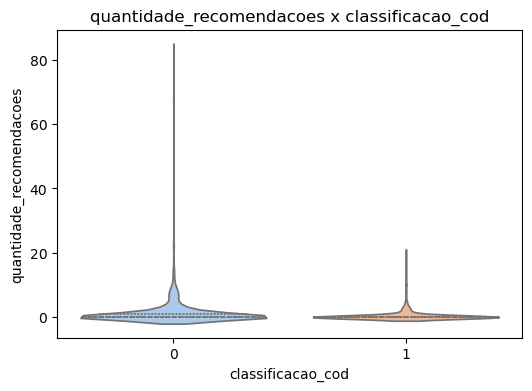

Correlação ponto-biserial (quantidade_recomendacoes vs classificacao_cod): -0.100, p-valor=5.679e-06



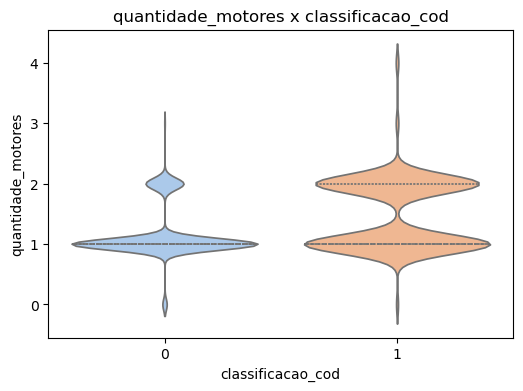

Correlação ponto-biserial (quantidade_motores vs classificacao_cod): 0.313, p-valor=1.850e-47



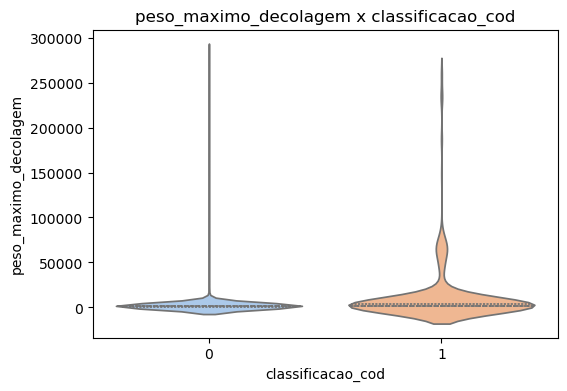

Correlação ponto-biserial (peso_maximo_decolagem vs classificacao_cod): 0.169, p-valor=1.576e-14

=== Atributos Categóricos ===


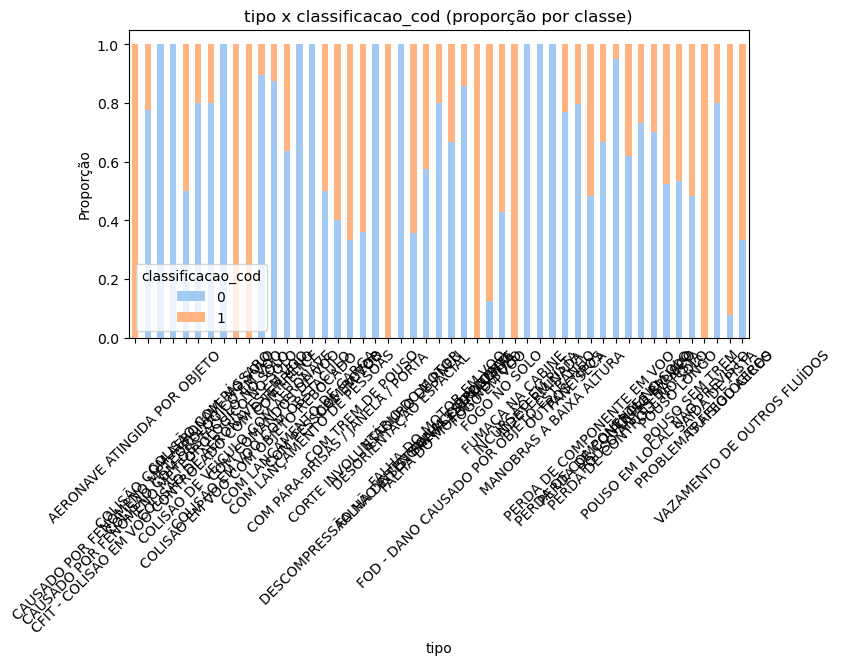

Cramér's V (tipo vs classificacao_cod): 0.457



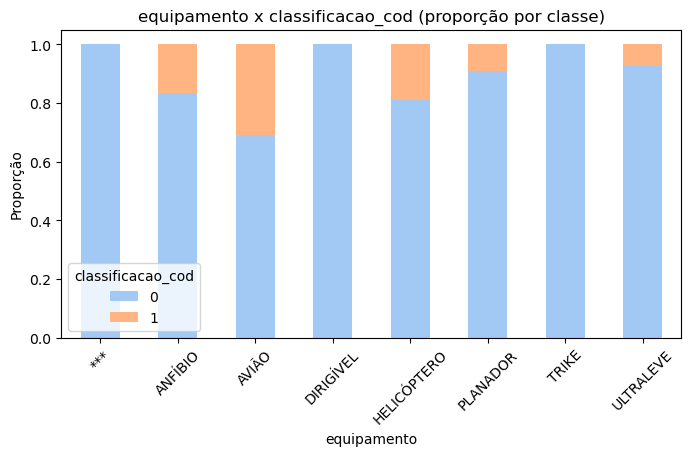

Cramér's V (equipamento vs classificacao_cod): 0.165



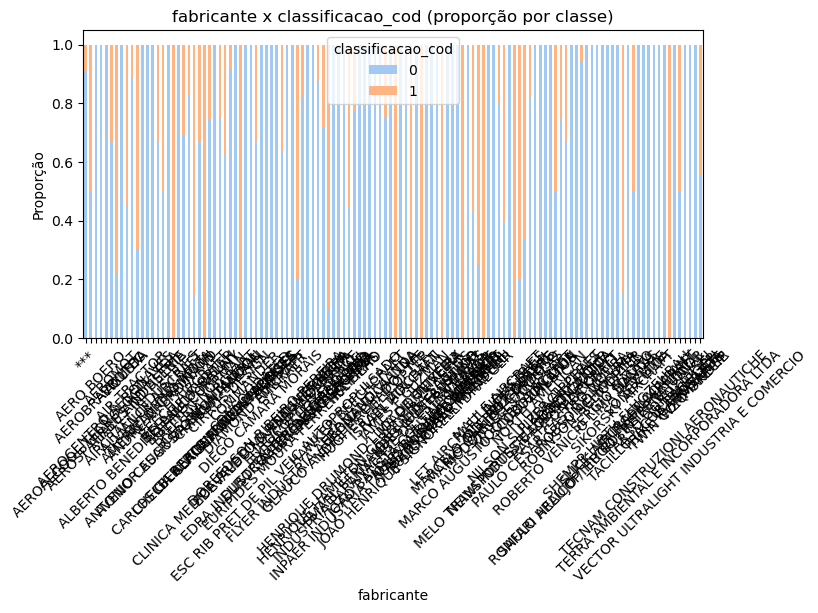

Cramér's V (fabricante vs classificacao_cod): 0.420



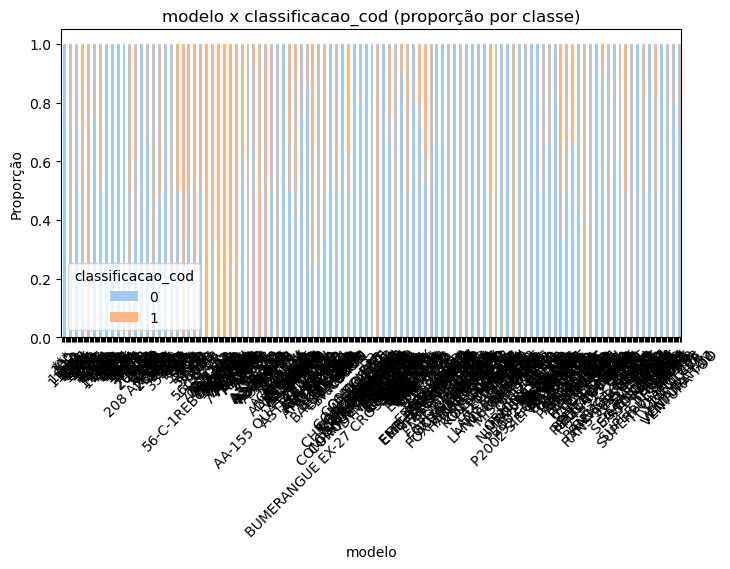

Cramér's V (modelo vs classificacao_cod): 0.626



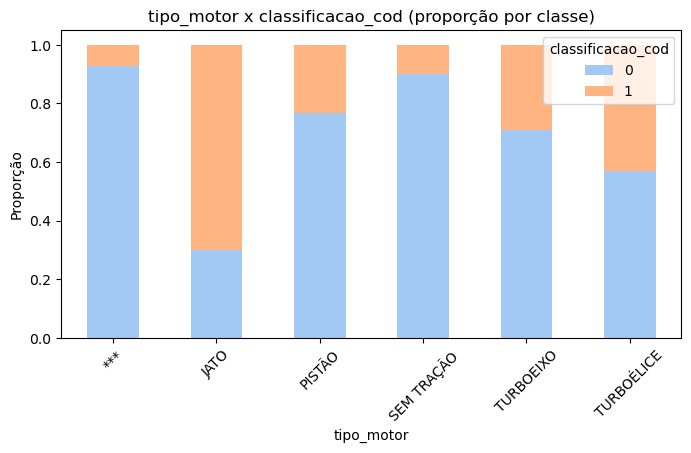

Cramér's V (tipo_motor vs classificacao_cod): 0.268



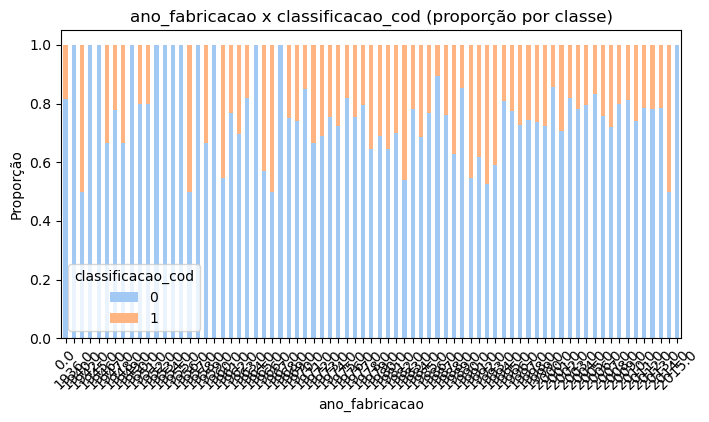

Cramér's V (ano_fabricacao vs classificacao_cod): 0.215



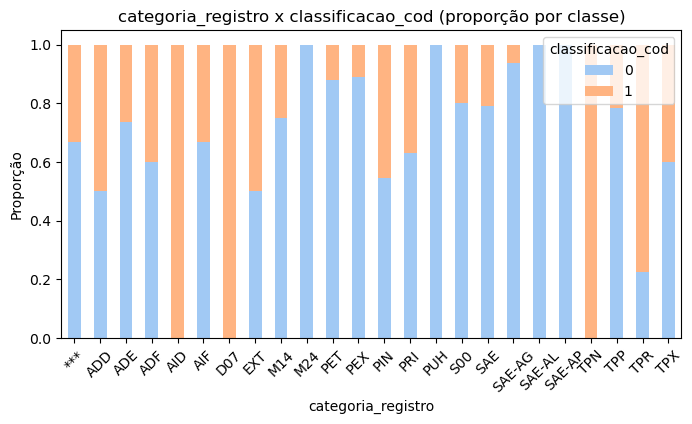

Cramér's V (categoria_registro vs classificacao_cod): 0.357



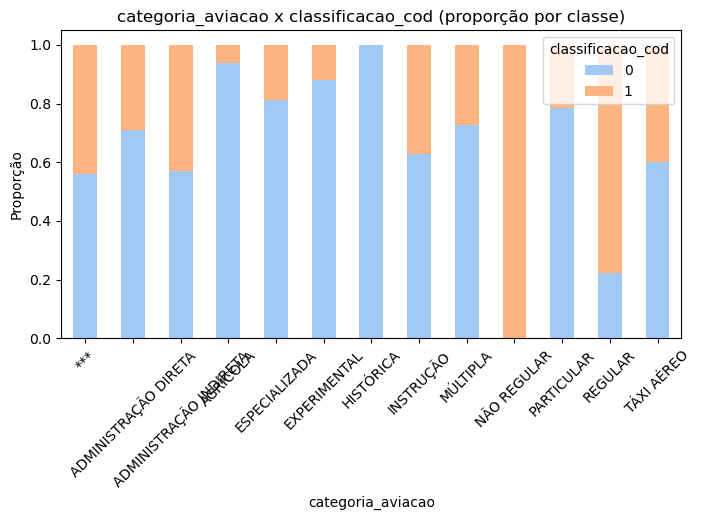

Cramér's V (categoria_aviacao vs classificacao_cod): 0.351



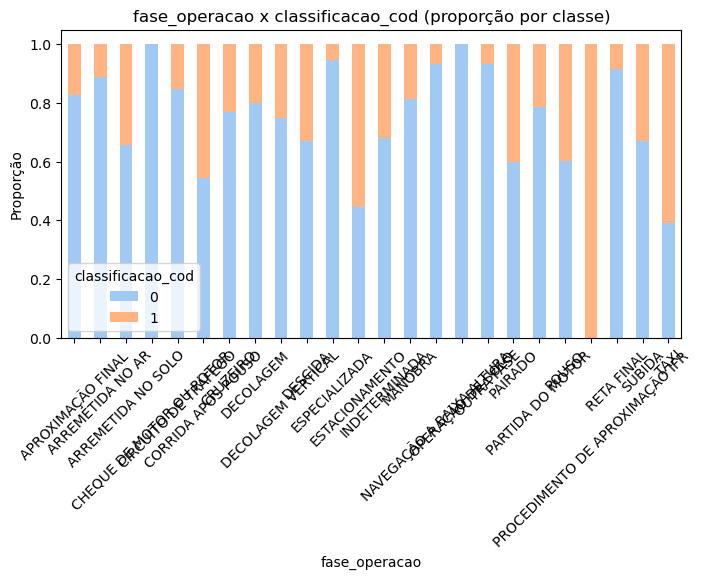

Cramér's V (fase_operacao vs classificacao_cod): 0.298



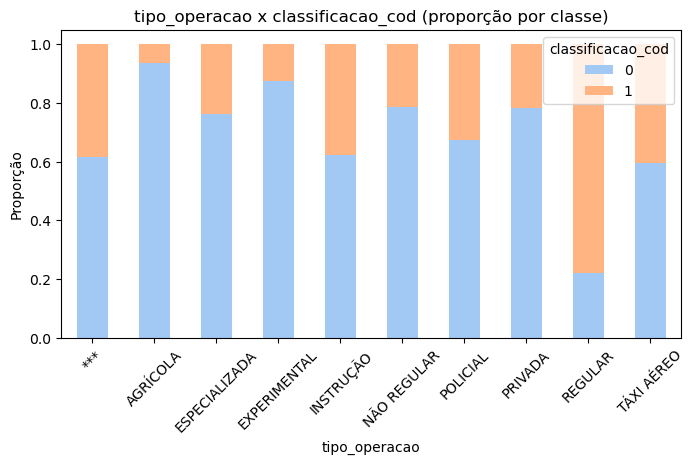

Cramér's V (tipo_operacao vs classificacao_cod): 0.350



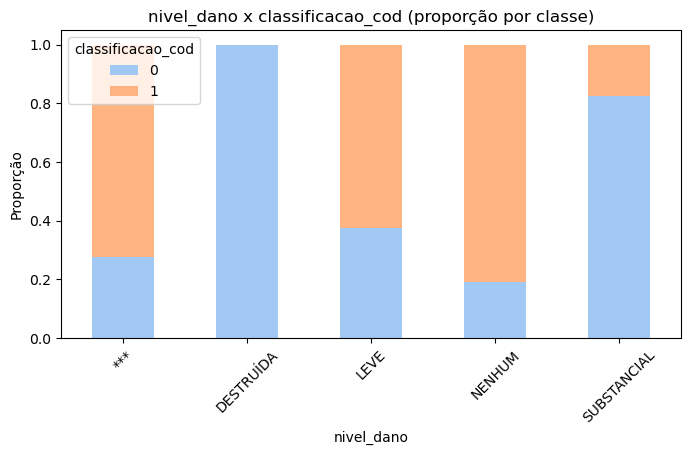

Cramér's V (nivel_dano vs classificacao_cod): 0.570



In [60]:
visualizar_relacao_alvo(
    data = df_join_limpo,
    alvo = "classificacao_cod",
    atributos_numericos = atributos_numericos,
    atributos_categoricos = atributos_categoricos
)

In [62]:
outras = ['ano_fabricacao', 'modelo', 'tipo']

for col in outras:
    print(f"\nPercentual de {col}:")
    print(df_join_limpo[col].value_counts(normalize=True).mul(100).round(2))


Percentual de ano_fabricacao:
ano_fabricacao
0.0       4.27
1980.0    4.02
1976.0    3.97
1992.0    3.92
1974.0    3.38
          ... 
1959.0    0.05
1936.0    0.05
1955.0    0.05
1942.0    0.05
1945.0    0.05
Name: proportion, Length: 75, dtype: float64

Percentual de modelo:
modelo
AB-115       5.43
EMB-202      3.82
EMB-201A     3.52
EMB-810C     2.99
EMB-810D     1.86
             ... 
A340         0.05
55C          0.05
RV-9         0.05
747-312M     0.05
DC-10-30F    0.05
Name: proportion, Length: 515, dtype: float64

Percentual de tipo:
tipo
FALHA DO MOTOR EM VOO                             18.45
PERDA DE CONTROLE NO SOLO                         15.91
PERDA DE CONTROLE EM VOO                          15.22
COLISÃO EM VOO COM OBSTÁCULO                       6.95
COM TREM DE POUSO                                  6.36
OUTROS TIPOS                                       4.26
PANE SECA                                          3.62
FALHA DE SISTEMA / COMPONENTE                      2

In [64]:
# Substitui 0 por NA no "ano_fabricacao"

if 'ano_fabricacao' in df_join_limpo.columns:
    df_join_limpo.loc[df_join_limpo['ano_fabricacao'] == 0, 'ano_fabricacao'] = np.nan

In [66]:
# Substitui "***" por NA em todas as colunas que tiver

df_join_limpo = df_join_limpo.replace('***', np.nan)

In [68]:
# Converter o ano para formato data

# Substituir valores inválidos por Na
df_join_limpo["ano_fabricacao"] = df_join_limpo["ano_fabricacao"].replace(0, np.nan)

# Converter para datetime (apenas o ano)
df_join_limpo["ano_fabricacao"] = pd.to_datetime(df_join_limpo["ano_fabricacao"], format="%Y", errors="coerce")

df_join_limpo["ano_fabricacao"] = df_join_limpo["ano_fabricacao"].dt.year.astype("Int64")

In [70]:
# Novo dataframe: seleção de variáveis

colunas_desejadas = ['classificacao_cod', 'tipo', 'equipamento', 'fabricante', 'modelo', 'tipo_motor', 'ano_fabricacao', 
                     'categoria_registro', 'categoria_aviacao', 'fase_operacao', 'tipo_operacao', 'nivel_dano', 
                     'quantidade_recomendacoes', 'quantidade_motores', 'peso_maximo_decolagem']

# Criar novo dataframe
df_select = df_join_limpo[colunas_desejadas].copy()

# Conferir as primeiras linhas
df_select.head()

,classificacao_cod,tipo,equipamento,fabricante,modelo,tipo_motor,ano_fabricacao,categoria_registro,categoria_aviacao,fase_operacao,tipo_operacao,nivel_dano,quantidade_recomendacoes,quantidade_motores,peso_maximo_decolagem
0,0,FALHA DO MOTOR EM VOO,ULTRALEVE,ORION LTDA,F1A EAGLE,PISTÃO,2005,PET,EXPERIMENTAL,CIRCUITO DE TRÁFEGO,EXPERIMENTAL,SUBSTANCIAL,0,1.0,450
1,1,POUSO SEM TREM,AVIÃO,EMBRAER,EMB-810C,PISTÃO,1980,TPX,TÁXI AÉREO,POUSO,TÁXI AÉREO,SUBSTANCIAL,0,2.0,2073
2,0,PERDA DE CONTROLE NO SOLO,AVIÃO,EMBRAER,EMB-820C NAVAJO,PISTÃO,1981,TPX,TÁXI AÉREO,CORRIDA APÓS POUSO,TÁXI AÉREO,SUBSTANCIAL,0,2.0,3175
3,0,POUSO LONGO,AVIÃO,CESSNA AIRCRAFT,U206G,PISTÃO,1981,TPX,TÁXI AÉREO,CORRIDA APÓS POUSO,TÁXI AÉREO,SUBSTANCIAL,4,1.0,1633
4,0,PERDA DE CONTROLE EM VOO,AVIÃO,CESSNA AIRCRAFT,A188B,PISTÃO,1973,SAE,ESPECIALIZADA,DECOLAGEM,ESPECIALIZADA,SUBSTANCIAL,0,1.0,1812


## Tratando os outliers

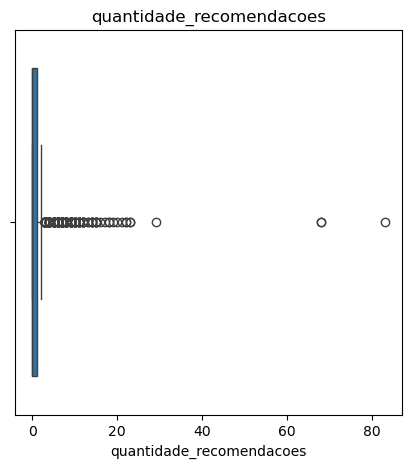

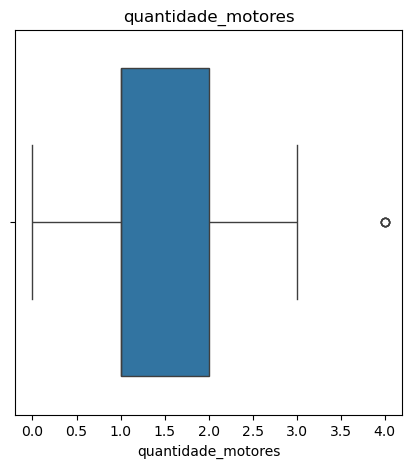

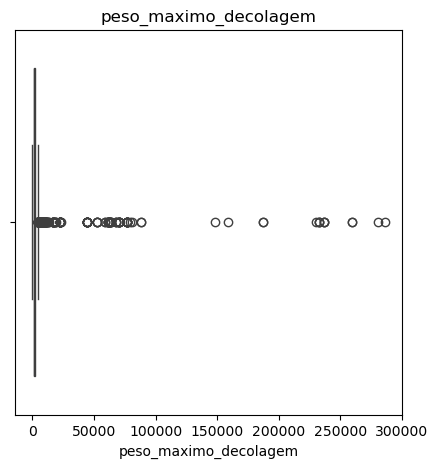

In [73]:
# Visualizando outliers para cada variável no DataFrame
for column in df_select.columns:
    if df_select[column].dtype in ['int64', 'float64']:  
        plt.figure(figsize = (5, 5))
        sns.boxplot(x = df_select[column])
        plt.title(column)
        plt.show()

In [75]:
# Seleciona apenas as colunas numéricas
df_num = df_select.select_dtypes(include=['number'])

# Define o Intervalo Interquartil
Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

classificacao_cod              1.0
ano_fabricacao                24.0
quantidade_recomendacoes       1.0
quantidade_motores             1.0
peso_maximo_decolagem       1311.0
dtype: Float64


In [77]:
# Selecionar somente as colunas pertinentes

colunas_iqr = ["quantidade_recomendacoes", 
               "quantidade_motores", 
               "peso_maximo_decolagem"]

# Calcula o IQR apenas para essas colunas
Q1 = df_select[colunas_iqr].quantile(0.25)
Q3 = df_select[colunas_iqr].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

quantidade_recomendacoes       1.0
quantidade_motores             1.0
peso_maximo_decolagem       1311.0
dtype: float64


In [79]:
# Vou checar os valores que estão 1.5 acima ou abaixo do IQR. Esses valores serão considerados outliers.
outliers = ((df_select[colunas_iqr] < (Q1 - 1.5 * IQR)) | 
            (df_select[colunas_iqr] > (Q3 + 1.5 * IQR)))

print(outliers.sum())

quantidade_recomendacoes    255
quantidade_motores            4
peso_maximo_decolagem       226
dtype: int64


In [81]:
# Filtrar os outliers
Q1 = df_select[colunas_iqr].quantile(0.25)
Q3 = df_select[colunas_iqr].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

mask_outliers = (
    (df_select[colunas_iqr] < limite_inferior) |
    (df_select[colunas_iqr] > limite_superior)
)

df_outliers = df_select[mask_outliers.any(axis=1)]

df_outliers[colunas_iqr]

,quantidade_recomendacoes,quantidade_motores,peso_maximo_decolagem
3,4,1.0,1633
8,3,1.0,1633
12,0,2.0,5670
14,21,1.0,2250
20,3,2.0,4750
...,...,...,...
2036,0,2.0,6849
2038,0,3.0,259455
2039,0,3.0,259455
2041,0,2.0,233000


In [83]:
# Selecionar somente quantidade de motores e manter os outros outliers

colunas_iqr = ["quantidade_motores",]

# Calcula o IQR apenas para essas colunas
Q1 = df_select[colunas_iqr].quantile(0.25)
Q3 = df_select[colunas_iqr].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

quantidade_motores    1.0
dtype: float64


In [85]:
# Ver os outliers com quantidade de motores
Q1 = df_select[colunas_iqr].quantile(0.25)
Q3 = df_select[colunas_iqr].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

mask_outliers = (
    (df_select[colunas_iqr] < limite_inferior) |
    (df_select[colunas_iqr] > limite_superior)
)

df_outliers = df_select[mask_outliers.any(axis=1)]

df_outliers[colunas_iqr]

,quantidade_motores
56,4.0
615,4.0
666,4.0
1484,4.0


In [87]:
# Remover as aeronaves que não sejam mono ou bimotores e representam valores baixos
df_select["quantidade_motores"] = pd.to_numeric(df_select["quantidade_motores"], errors="coerce")
df_select["quantidade_motores"] = df_select["quantidade_motores"].where(df_select["quantidade_motores"].isin([1, 2]), np.nan)
df_select["quantidade_motores"] = df_select["quantidade_motores"].astype("Int64")

In [89]:
tabela_categorias = df_select["quantidade_motores"].value_counts(dropna=False).reset_index()
tabela_categorias.columns = ["quantidade_motores", "frequencia"]

print(tabela_categorias)

   quantidade_motores  frequencia
0                   1        1490
1                   2         502
2                <NA>          51


## Tratando os valores ausentes

In [92]:
missing = df_select.isna().mean() * 100
missing = missing[missing > 0].sort_values(ascending=False)

print(missing)

fabricante            5.384239
ano_fabricacao        4.454234
nivel_dano            3.377386
quantidade_motores    2.496329
tipo_motor            1.370534
tipo_operacao         1.272638
categoria_aviacao     1.223691
modelo                0.734214
categoria_registro    0.440529
equipamento           0.244738
dtype: float64


In [94]:
df_select.head()

,classificacao_cod,tipo,equipamento,fabricante,modelo,tipo_motor,ano_fabricacao,categoria_registro,categoria_aviacao,fase_operacao,tipo_operacao,nivel_dano,quantidade_recomendacoes,quantidade_motores,peso_maximo_decolagem
0,0,FALHA DO MOTOR EM VOO,ULTRALEVE,ORION LTDA,F1A EAGLE,PISTÃO,2005,PET,EXPERIMENTAL,CIRCUITO DE TRÁFEGO,EXPERIMENTAL,SUBSTANCIAL,0,1,450
1,1,POUSO SEM TREM,AVIÃO,EMBRAER,EMB-810C,PISTÃO,1980,TPX,TÁXI AÉREO,POUSO,TÁXI AÉREO,SUBSTANCIAL,0,2,2073
2,0,PERDA DE CONTROLE NO SOLO,AVIÃO,EMBRAER,EMB-820C NAVAJO,PISTÃO,1981,TPX,TÁXI AÉREO,CORRIDA APÓS POUSO,TÁXI AÉREO,SUBSTANCIAL,0,2,3175
3,0,POUSO LONGO,AVIÃO,CESSNA AIRCRAFT,U206G,PISTÃO,1981,TPX,TÁXI AÉREO,CORRIDA APÓS POUSO,TÁXI AÉREO,SUBSTANCIAL,4,1,1633
4,0,PERDA DE CONTROLE EM VOO,AVIÃO,CESSNA AIRCRAFT,A188B,PISTÃO,1973,SAE,ESPECIALIZADA,DECOLAGEM,ESPECIALIZADA,SUBSTANCIAL,0,1,1812


In [96]:
# Separar colunas categóricas e numéricas
colunas_categoricas = ["fabricante", "nivel_dano", "tipo_motor", "tipo_operacao", "categoria_aviacao", "modelo", "categoria_registro",
                        "equipamento"]
colunas_numericas = ["ano_fabricacao", "quantidade_motores"]

# Imputação categórica (moda)
for col in colunas_categoricas:
    df_select[col] = df_select[col].fillna(df_select[col].mode()[0])

# Imputação numérica (mediana)
for col in colunas_numericas:
    df_select[col] = df_select[col].fillna(df_select[col].median())

## Aplicar KMeans para agrupar categorias

In [ ]:
# Verificar se há multicolinearidade entre as variáveis

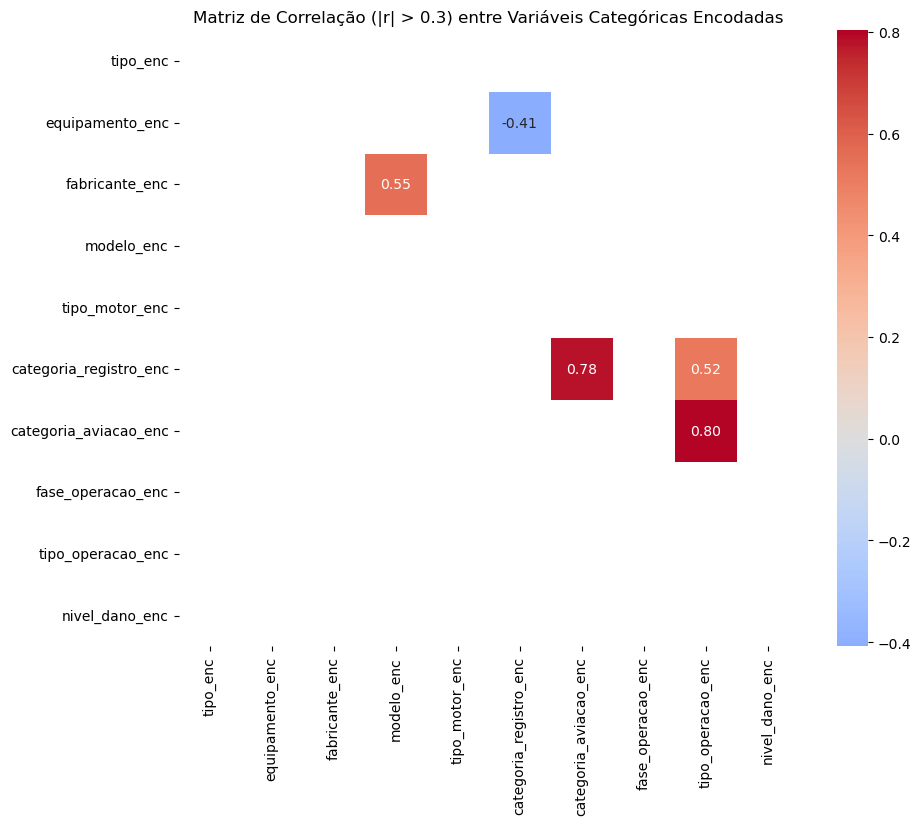

In [99]:
# Calcular a matriz de correlação
variaveis = ["tipo", "equipamento", "fabricante", "modelo", "tipo_motor", "categoria_registro", 
             "categoria_aviacao", "fase_operacao", "tipo_operacao", "nivel_dano"]

# Cria uma cópia
df_enc = df_select.copy()

# Label Encoding
le = LabelEncoder()
for col in variaveis:
    if df_enc[col].dtype == 'object':
        df_enc[col + "_enc"] = le.fit_transform(df_enc[col].astype(str))


# calcula a correlação entre as variáveis encodadas
variaveis_enc = [col + "_enc" for col in variaveis]
corr_matrix = df_enc[variaveis_enc].corr()

# Filtrar apenas correlações acima de 0.3 (em módulo) e sem diagonal
corr_filtrada = corr_matrix.mask(np.tril(np.ones(corr_matrix.shape)).astype(bool))
corr_filtrada = corr_filtrada[(corr_filtrada.abs() > 0.3)]

plt.figure(figsize=(10,8))
sns.heatmap(corr_filtrada, annot=True, cmap="coolwarm", fmt=".2f", center=0)
plt.title("Matriz de Correlação (|r| > 0.3) entre Variáveis Categóricas Encodadas")
plt.show()

In [101]:
# Remover colunas fabricante, categoria_registro_enc e categoria_aviacao_enc

df_enc = df_enc.drop(columns=['fabricante', 'fabricante_enc', 'categoria_registro', 'categoria_registro_enc', 'categoria_aviacao', 'categoria_aviacao_enc'])

In [103]:
df_enc.head()

,classificacao_cod,tipo,equipamento,modelo,tipo_motor,ano_fabricacao,fase_operacao,tipo_operacao,nivel_dano,quantidade_recomendacoes,quantidade_motores,peso_maximo_decolagem,tipo_enc,equipamento_enc,modelo_enc,tipo_motor_enc,fase_operacao_enc,tipo_operacao_enc,nivel_dano_enc
0,0,FALHA DO MOTOR EM VOO,ULTRALEVE,F1A EAGLE,PISTÃO,2005,CIRCUITO DE TRÁFEGO,EXPERIMENTAL,SUBSTANCIAL,0,1,450,24,6,311,1,4,2,3
1,1,POUSO SEM TREM,AVIÃO,EMB-810C,PISTÃO,1980,POUSO,TÁXI AÉREO,SUBSTANCIAL,0,2,2073,44,1,300,1,19,8,3
2,0,PERDA DE CONTROLE NO SOLO,AVIÃO,EMB-820C NAVAJO,PISTÃO,1981,CORRIDA APÓS POUSO,TÁXI AÉREO,SUBSTANCIAL,0,2,3175,39,1,303,1,5,8,3
3,0,POUSO LONGO,AVIÃO,U206G,PISTÃO,1981,CORRIDA APÓS POUSO,TÁXI AÉREO,SUBSTANCIAL,4,1,1633,43,1,506,1,5,8,3
4,0,PERDA DE CONTROLE EM VOO,AVIÃO,A188B,PISTÃO,1973,DECOLAGEM,ESPECIALIZADA,SUBSTANCIAL,0,1,1812,38,1,159,1,7,1,3


In [105]:
# Padronizar variáveis numéricas para que todas estejam na mesma escala

# a variavel ano de fabricação foi padronizada, pois entende-se que há relevância na idade da aeronave (modelo mais novo x modelo mais antigo)

# Selecionar apenas as variáveis numéricas
var_numericas = ["ano_fabricacao", 
    "quantidade_recomendacoes", 
    "quantidade_motores", 
    "peso_maximo_decolagem"]

df_numericas = df_select[var_numericas]

# Cria o padronizador
scaler = StandardScaler()

# Padronizar os dados
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_numericas),
    columns=df_numericas.columns,
    index=df_select.index
)


In [107]:
# Unir com as variaveis categoricas

df_final = pd.concat([df_scaled, df_enc.select_dtypes(exclude=['int64', 'float64'])], axis=1)

df_final.head()

,ano_fabricacao,quantidade_recomendacoes,quantidade_motores,peso_maximo_decolagem,classificacao_cod,tipo,equipamento,modelo,tipo_motor,fase_operacao,tipo_operacao,nivel_dano,tipo_enc,equipamento_enc,modelo_enc,tipo_motor_enc,fase_operacao_enc,tipo_operacao_enc,nivel_dano_enc
0,1.182296,-0.303484,-0.570756,-0.221824,0,FALHA DO MOTOR EM VOO,ULTRALEVE,F1A EAGLE,PISTÃO,CIRCUITO DE TRÁFEGO,EXPERIMENTAL,SUBSTANCIAL,24,6,311,1,4,2,3
1,-0.485312,-0.303484,1.752062,-0.148049,1,POUSO SEM TREM,AVIÃO,EMB-810C,PISTÃO,POUSO,TÁXI AÉREO,SUBSTANCIAL,44,1,300,1,19,8,3
2,-0.418608,-0.303484,1.752062,-0.097956,0,PERDA DE CONTROLE NO SOLO,AVIÃO,EMB-820C NAVAJO,PISTÃO,CORRIDA APÓS POUSO,TÁXI AÉREO,SUBSTANCIAL,39,1,303,1,5,8,3
3,-0.418608,0.734637,-0.570756,-0.168050,0,POUSO LONGO,AVIÃO,U206G,PISTÃO,CORRIDA APÓS POUSO,TÁXI AÉREO,SUBSTANCIAL,43,1,506,1,5,8,3
4,-0.952243,-0.303484,-0.570756,-0.159913,0,PERDA DE CONTROLE EM VOO,AVIÃO,A188B,PISTÃO,DECOLAGEM,ESPECIALIZADA,SUBSTANCIAL,38,1,159,1,7,1,3


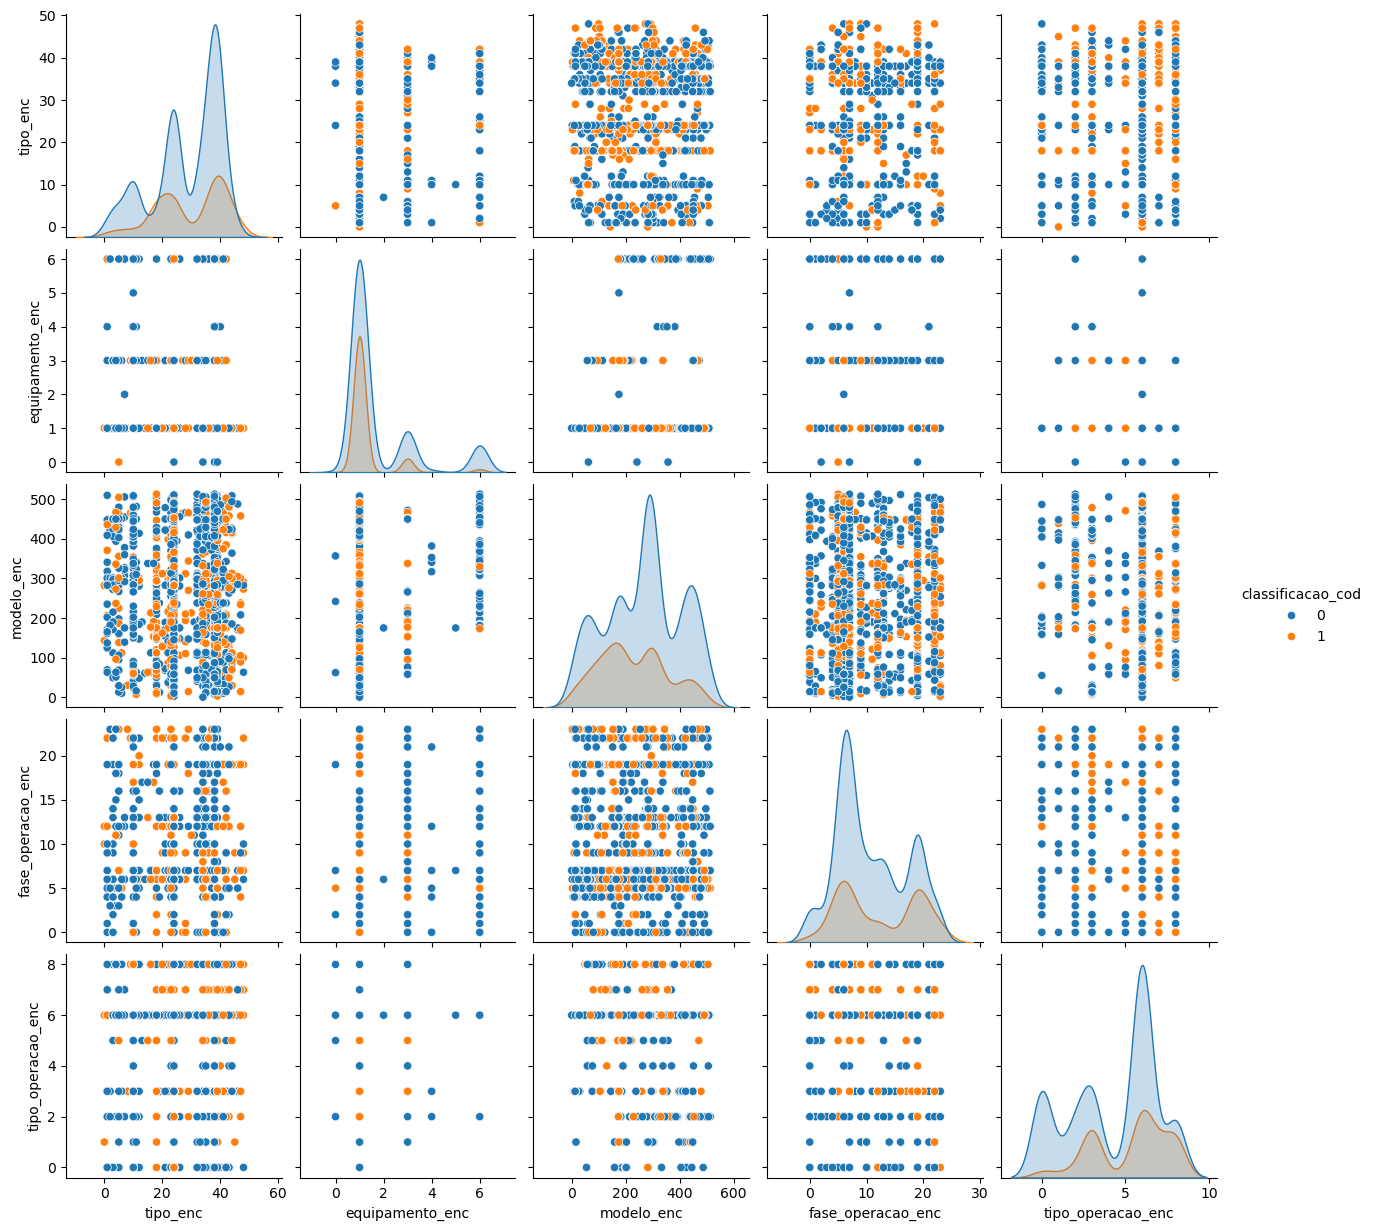

In [109]:
# Visualização de Dados com PairPlot

# Lista das variáveis encodadas
vars_categoricas = ['tipo', 'equipamento', 'modelo', 'fase_operacao', 'tipo_operacao']

# Nome das colunas encodadas
vars_enc = [col + "_enc" for col in vars_categoricas]

# Criar um novo DataFrame incluindo a variável alvo para hue
df_pairplot = df_final[vars_enc + ['classificacao_cod']].copy()

# Plotar pairplot
sns.pairplot(df_pairplot, hue='classificacao_cod', diag_kind='kde')
plt.show()

# Realizar K-Means nas seguintes variáveis: tipo, equipamento, modelo, fase operação, tipo_operacao

In [112]:
# TIPO
X_tipo = df_final[['tipo_enc']]

inertia = []
k_range = range(1, 11)  

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tipo)
    inertia.append(kmeans.inertia_)

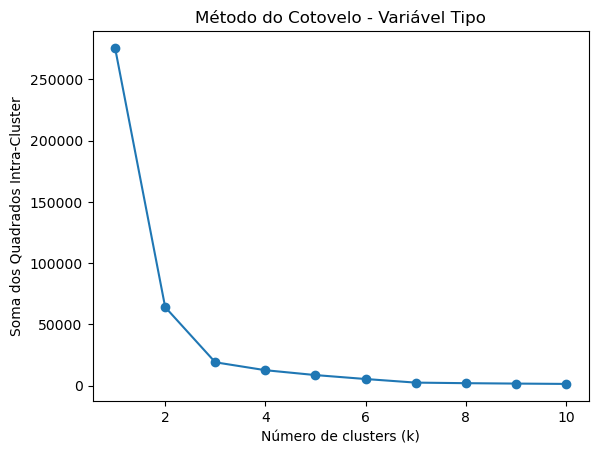

In [114]:
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Soma dos Quadrados Intra-Cluster')
plt.title('Método do Cotovelo - Variável Tipo')
plt.show()

In [116]:
# Aplicar K-Means com 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df_final['tipo_cluster'] = kmeans.fit_predict(X_tipo)

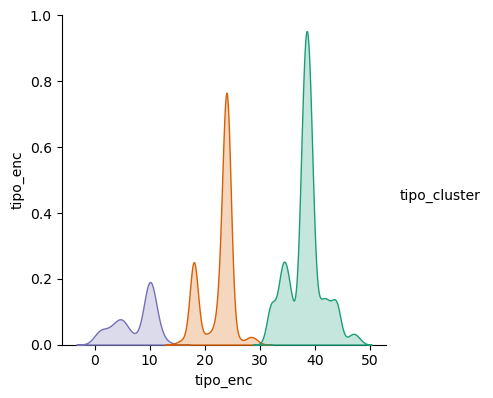

In [118]:
df_plot = df_final[['tipo_enc', 'tipo_cluster']].copy()

sns.pairplot(df_plot, x_vars=['tipo_enc'], y_vars=['tipo_enc'],
             hue='tipo_cluster', diag_kind='kde', height=4, palette='Dark2')

plt.show()

In [120]:
# EQUIPAMENTO
X_equipamento = df_final[['equipamento_enc']]

inertia = []
k_range = range(1, 11)  

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_equipamento)
    inertia.append(kmeans.inertia_)

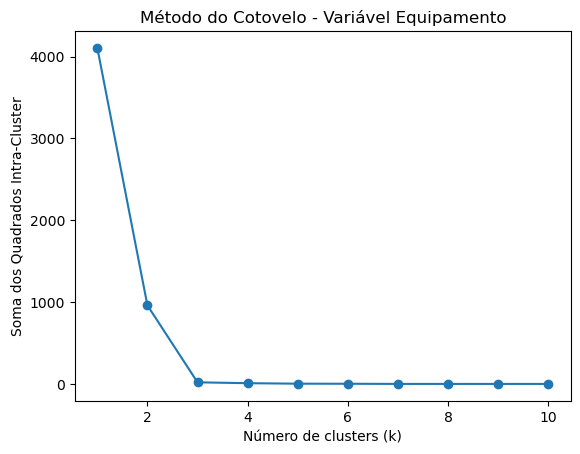

In [122]:
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Soma dos Quadrados Intra-Cluster')
plt.title('Método do Cotovelo - Variável Equipamento')
plt.show()

In [124]:
# Aplicar K-Means com 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df_final['equipamento_cluster'] = kmeans.fit_predict(X_equipamento)

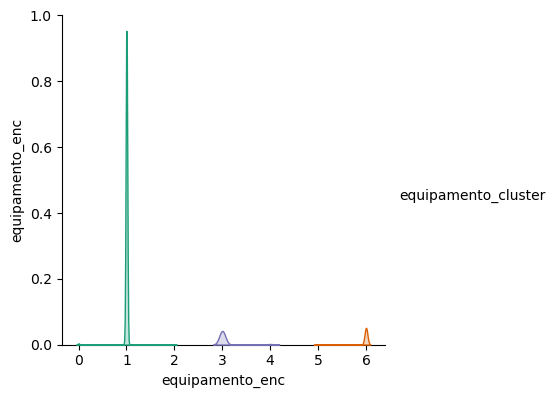

In [126]:
df_plot = df_final[['equipamento_enc', 'equipamento_cluster']].copy()

sns.pairplot(df_plot, x_vars=['equipamento_enc'], y_vars=['equipamento_enc'],
             hue='equipamento_cluster', diag_kind='kde', height=4, palette='Dark2')

plt.show()

In [128]:
# MODELO

X_modelo = df_final[['modelo_enc']]

inertia = []
k_range = range(1, 11)  

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_modelo)
    inertia.append(kmeans.inertia_)

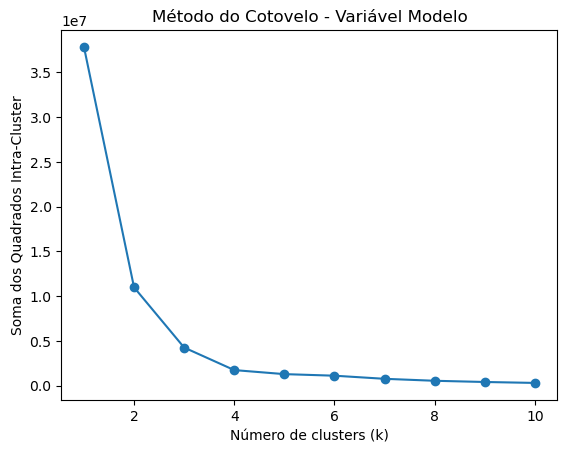

In [130]:
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Soma dos Quadrados Intra-Cluster')
plt.title('Método do Cotovelo - Variável Modelo')
plt.show()

In [132]:
# Aplicar K-Means com 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df_final['modelo_cluster'] = kmeans.fit_predict(X_modelo)

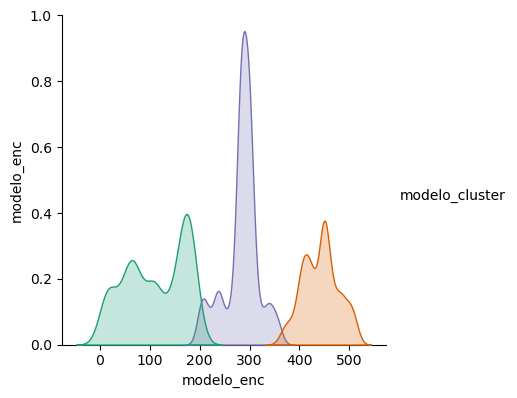

In [134]:
df_plot = df_final[['modelo_enc', 'modelo_cluster']].copy()

sns.pairplot(df_plot, x_vars=['modelo_enc'], y_vars=['modelo_enc'],
             hue='modelo_cluster', diag_kind='kde', height=4, palette='Dark2')

plt.show()

In [136]:
# FASE DE OPERAÇÃO
X_fase = df_final[['fase_operacao_enc']]

inertia = []
k_range = range(1, 11)  

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_fase)
    inertia.append(kmeans.inertia_)

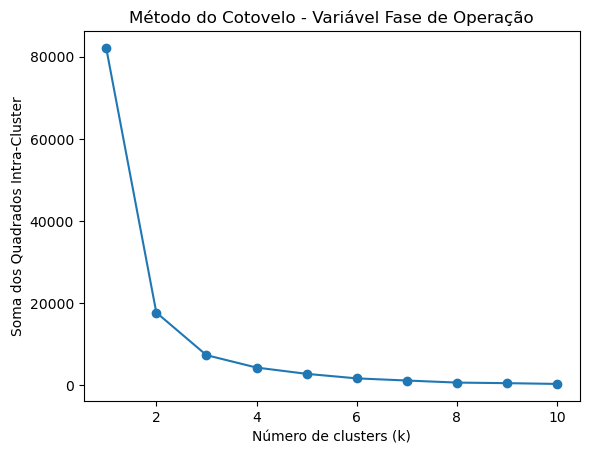

In [138]:
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Soma dos Quadrados Intra-Cluster')
plt.title('Método do Cotovelo - Variável Fase de Operação')
plt.show()

In [140]:
# Aplicar K-Means com 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df_final['fase_operacao_cluster'] = kmeans.fit_predict(X_fase)

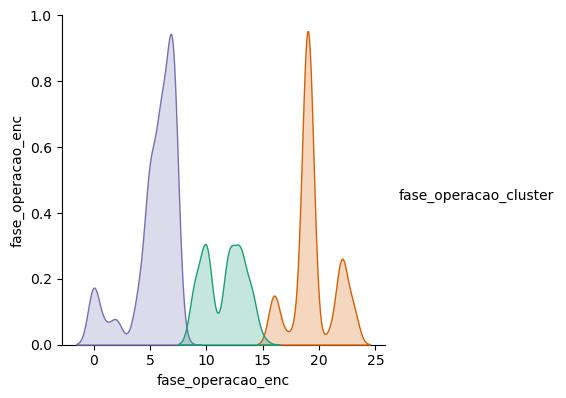

In [142]:
df_plot = df_final[['fase_operacao_enc', 'fase_operacao_cluster']].copy()

sns.pairplot(df_plot, x_vars=['fase_operacao_enc'], y_vars=['fase_operacao_enc'],
             hue='fase_operacao_cluster', diag_kind='kde', height=4, palette='Dark2')

plt.show()

In [144]:
# TIPO DE OPERACAO
X_tipo_operacao = df_final[['tipo_operacao_enc']]

inertia = []
k_range = range(1, 11)  

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tipo_operacao)
    inertia.append(kmeans.inertia_)

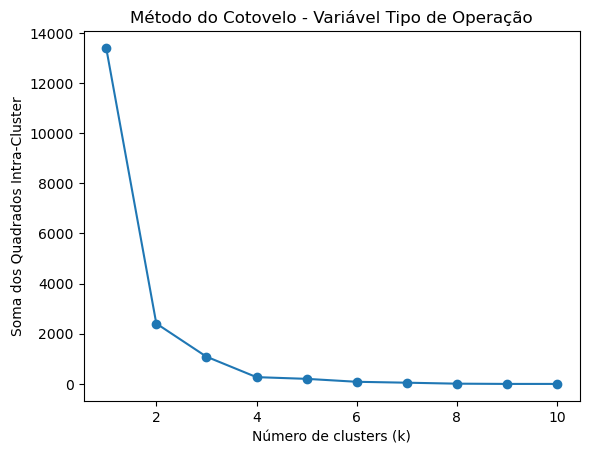

In [146]:
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Soma dos Quadrados Intra-Cluster')
plt.title('Método do Cotovelo - Variável Tipo de Operação')
plt.show()

In [148]:
# Aplicar K-Means com 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df_final['tipo_operacao_cluster'] = kmeans.fit_predict(X_tipo_operacao)

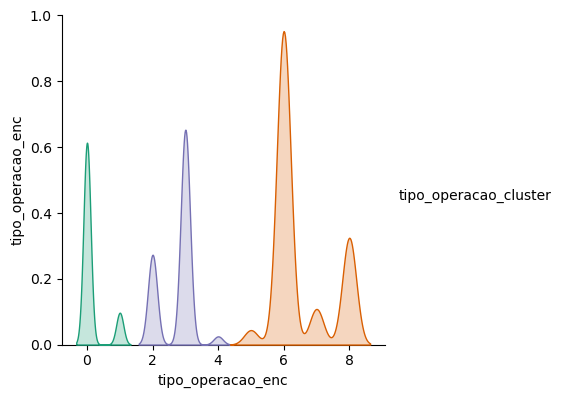

In [150]:
df_plot = df_final[['tipo_operacao_enc', 'tipo_operacao_cluster']].copy()

sns.pairplot(df_plot, x_vars=['tipo_operacao_enc'], y_vars=['tipo_operacao_enc'],
             hue='tipo_operacao_cluster', diag_kind='kde', height=4, palette='Dark2')

plt.show()

# Analisar os clusters escolhidos

In [153]:
df_final.head(5)

,ano_fabricacao,quantidade_recomendacoes,quantidade_motores,peso_maximo_decolagem,classificacao_cod,tipo,equipamento,modelo,tipo_motor,fase_operacao,...,modelo_enc,tipo_motor_enc,fase_operacao_enc,tipo_operacao_enc,nivel_dano_enc,tipo_cluster,equipamento_cluster,modelo_cluster,fase_operacao_cluster,tipo_operacao_cluster
0,1.182296,-0.303484,-0.570756,-0.221824,0,FALHA DO MOTOR EM VOO,ULTRALEVE,F1A EAGLE,PISTÃO,CIRCUITO DE TRÁFEGO,...,311,1,4,2,3,1,1,2,2,2
1,-0.485312,-0.303484,1.752062,-0.148049,1,POUSO SEM TREM,AVIÃO,EMB-810C,PISTÃO,POUSO,...,300,1,19,8,3,0,0,2,1,1
2,-0.418608,-0.303484,1.752062,-0.097956,0,PERDA DE CONTROLE NO SOLO,AVIÃO,EMB-820C NAVAJO,PISTÃO,CORRIDA APÓS POUSO,...,303,1,5,8,3,0,0,2,2,1
3,-0.418608,0.734637,-0.570756,-0.168050,0,POUSO LONGO,AVIÃO,U206G,PISTÃO,CORRIDA APÓS POUSO,...,506,1,5,8,3,0,0,1,2,1
4,-0.952243,-0.303484,-0.570756,-0.159913,0,PERDA DE CONTROLE EM VOO,AVIÃO,A188B,PISTÃO,DECOLAGEM,...,159,1,7,1,3,0,0,0,2,0


In [155]:
df_final[df_final.tipo_cluster == 0][['tipo', 'tipo_cluster']].head(10)

,tipo,tipo_cluster
1,POUSO SEM TREM,0
2,PERDA DE CONTROLE NO SOLO,0
3,POUSO LONGO,0
4,PERDA DE CONTROLE EM VOO,0
6,PERDA DE CONTROLE EM VOO,0
9,INDETERMINADA,0
10,PERDA DE CONTROLE EM VOO,0
13,INCURSÃO EM PISTA,0
14,PERDA DE CONTROLE EM VOO,0
16,POUSO BRUSCO,0


In [157]:
df_final[df_final.tipo_cluster == 1][['tipo', 'tipo_motor', 'tipo_cluster']].head(10)

,tipo,tipo_motor,tipo_cluster
0,FALHA DO MOTOR EM VOO,PISTÃO,1
5,FALHA DO MOTOR EM VOO,PISTÃO,1
7,FALHA DO MOTOR EM VOO,PISTÃO,1
8,FALHA DO MOTOR EM VOO,PISTÃO,1
11,COM TREM DE POUSO,PISTÃO,1
17,FALHA DO MOTOR EM VOO,PISTÃO,1
19,COM ROTOR,TURBOEIXO,1
20,FALHA DE SISTEMA / COMPONENTE,JATO,1
23,FALHA DO MOTOR EM VOO,PISTÃO,1
24,COM PÁRA-BRISAS / JANELA / PORTA,TURBOÉLICE,1


In [159]:
df_final[df_final.equipamento_cluster == 0][['equipamento', 'equipamento_cluster']].head(5)

,equipamento,equipamento_cluster
1,AVIÃO,0
2,AVIÃO,0
3,AVIÃO,0
4,AVIÃO,0
5,AVIÃO,0


In [161]:
df_final[df_final.equipamento_cluster == 1][['equipamento', 'equipamento_cluster']].head(5)

,equipamento,equipamento_cluster
0,ULTRALEVE,1
15,ULTRALEVE,1
49,ULTRALEVE,1
53,ULTRALEVE,1
54,ULTRALEVE,1


In [163]:
df_final[df_final.fase_operacao_cluster == 0][['fase_operacao', 'fase_operacao_cluster']].head(10)

,fase_operacao,fase_operacao_cluster
5,MANOBRA,0
9,INDETERMINADA,0
10,DESCIDA,0
12,NAVEGAÇÃO A BAIXA ALTURA,0
13,ESTACIONAMENTO,0
14,INDETERMINADA,0
18,OPERAÇÃO DE SOLO,0
22,NAVEGAÇÃO A BAIXA ALTURA,0
25,NAVEGAÇÃO A BAIXA ALTURA,0
28,INDETERMINADA,0


In [165]:
df_final[df_final.fase_operacao_cluster == 1][['fase_operacao', 'fase_operacao_cluster']].head(10)

,fase_operacao,fase_operacao_cluster
1,POUSO,1
6,POUSO,1
15,POUSO,1
19,PAIRADO,1
21,POUSO,1
23,SUBIDA,1
26,POUSO,1
29,SUBIDA,1
32,SUBIDA,1
34,SUBIDA,1


## Divisão dos Dados Mantendo a Prevalência de Classe

In [168]:
# Gerando amostras aleatórias dos dados, com o mesmo tamanho, só para embaralhar ainda mais os dados e ficar mais aleatório
df_data = df_final.sample(n = len(df_join_limpo))

In [170]:
# Lista de colunas a remover
colunas_remover = [
    "tipo", "equipamento", "modelo", "fase_operacao", "tipo_operacao", 
    "tipo_enc", "equipamento_enc", "modelo_enc", "fase_operacao_enc", 
    "tipo_operacao_enc", "tipo_motor", "nivel_dano"
]

df_data = df_data.drop(columns=colunas_remover)

In [172]:
df_data

,ano_fabricacao,quantidade_recomendacoes,quantidade_motores,peso_maximo_decolagem,classificacao_cod,tipo_motor_enc,nivel_dano_enc,tipo_cluster,equipamento_cluster,modelo_cluster,fase_operacao_cluster,tipo_operacao_cluster
218,-0.752130,0.215577,1.752062,0.012276,1,4,2,1,0,2,1,1
1029,-0.085086,-0.303484,-0.570756,-0.160458,0,1,0,0,0,2,0,1
1332,-0.418608,-0.303484,1.752062,-0.130957,0,1,0,0,0,0,1,1
1370,0.248435,-0.303484,-0.570756,-0.207278,1,1,3,0,0,0,2,2
875,0.048322,-0.303484,-0.570756,-0.176323,0,3,3,1,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
126,-0.752130,-0.303484,1.752062,-0.148049,1,1,2,0,0,2,1,1
300,1.182296,-0.303484,1.752062,-0.128866,1,1,3,0,0,2,2,1
1406,0.448548,-0.303484,-0.570756,-0.160458,0,1,3,0,0,2,1,0
1781,-1.152356,-0.303484,-0.570756,-0.197960,0,1,3,0,0,1,1,2


In [174]:
# Ajustando os índices do dataset
df_data = df_data.reset_index(drop = True)

In [176]:
df_data

,ano_fabricacao,quantidade_recomendacoes,quantidade_motores,peso_maximo_decolagem,classificacao_cod,tipo_motor_enc,nivel_dano_enc,tipo_cluster,equipamento_cluster,modelo_cluster,fase_operacao_cluster,tipo_operacao_cluster
0,-0.752130,0.215577,1.752062,0.012276,1,4,2,1,0,2,1,1
1,-0.085086,-0.303484,-0.570756,-0.160458,0,1,0,0,0,2,0,1
2,-0.418608,-0.303484,1.752062,-0.130957,0,1,0,0,0,0,1,1
3,0.248435,-0.303484,-0.570756,-0.207278,1,1,3,0,0,0,2,2
4,0.048322,-0.303484,-0.570756,-0.176323,0,3,3,1,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2038,-0.752130,-0.303484,1.752062,-0.148049,1,1,2,0,0,2,1,1
2039,1.182296,-0.303484,1.752062,-0.128866,1,1,3,0,0,2,2,1
2040,0.448548,-0.303484,-0.570756,-0.160458,0,1,3,0,0,2,1,0
2041,-1.152356,-0.303484,-0.570756,-0.197960,0,1,3,0,0,1,1,2


In [178]:
# Extrair uma amostra de 30% dos dados de forma aleatória
df_amostra_30 = df_data.sample(frac = 0.3)

In [180]:
df_amostra_30

,ano_fabricacao,quantidade_recomendacoes,quantidade_motores,peso_maximo_decolagem,classificacao_cod,tipo_motor_enc,nivel_dano_enc,tipo_cluster,equipamento_cluster,modelo_cluster,fase_operacao_cluster,tipo_operacao_cluster
730,-0.018382,-0.303484,-0.570756,-0.242280,0,1,3,0,0,0,0,1
194,-1.018947,-0.303484,1.752062,-0.139185,0,1,3,0,0,0,1,1
139,0.448548,0.475107,-0.570756,-0.146821,0,3,0,1,2,0,2,1
1473,0.715366,-0.303484,-0.570756,-0.160458,0,1,3,1,0,2,2,0
1721,1.382409,2.032288,-0.570756,-0.140003,0,3,0,2,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1499,-0.685426,-0.303484,-0.570756,-0.209279,0,1,3,2,0,0,1,2
658,-0.018382,-0.303484,-0.570756,-0.218415,0,1,0,0,1,2,0,2
1982,1.582522,-0.303484,-0.570756,-0.215006,0,1,3,0,1,1,0,2
1331,-0.485312,-0.303484,-0.570756,-0.187641,0,1,3,0,0,0,1,1


In [182]:
# Fazendo a divisão

# Dados de teste (50% da amostra de 30% para teste)
df_teste = df_amostra_30.sample(frac = 0.5)

# Dados se validação (o restante fica para a validação)
df_valid = df_amostra_30.drop(df_teste.index)

# Dados de treino (os 70% ficam para treino)
df_treino = df_data.drop(df_amostra_30.index)

In [184]:
# Verificar a prevalência de cada subconjunto
print(
    "Teste(n = %d): %.3f"
    % (len(df_teste), calcula_prevalencia(df_teste.classificacao_cod.values))
)
print(
    "Validação(n = %d): %.3f"
    % (len(df_valid), calcula_prevalencia(df_valid.classificacao_cod.values))
)
print(
    "Treino(n = %d): %.3f"
    % (len(df_treino), calcula_prevalencia(df_treino.classificacao_cod.values))
)

Teste(n = 306): 0.248
Validação(n = 307): 0.280
Treino(n = 1430): 0.278


## Balanceamento de Classe

In [187]:
df_treino.classificacao_cod.value_counts()

classificacao_cod
0    1033
1     397
Name: count, dtype: int64

In [189]:
# Criar um índice com True/False
indice = df_treino.classificacao_cod == 1

In [193]:
# Definir valores positivos e negativos do índice
df_train_pos = df_treino.loc[indice]
df_train_neg = df_treino.loc[~indice]

In [195]:
# Valor mínimo de registros entre classe positiva e negativa
valor_minimo = np.min([len(df_train_pos), len(df_train_neg)])

In [197]:
valor_minimo

397

In [199]:
# Obter valores aleatórios para o dataset de treino
df_treino_final = pd.concat([df_train_pos.sample(n = valor_minimo, random_state = 69), 
                             df_train_neg.sample(n = valor_minimo, random_state = 69)], 
                            axis = 0, 
                            ignore_index = True)

In [201]:
# Amostragem aleatória do dataset de treino
df_treino_final = df_treino_final.sample(n = len(df_treino_final), random_state = 69).reset_index(drop = True)

In [203]:
df_treino_final.shape

(794, 12)

In [205]:
df_treino_final.classificacao_cod.value_counts()

classificacao_cod
0    397
1    397
Name: count, dtype: int64

In [207]:
# Balanceamento do conjunto de dados
print('Balanceamento em Treino(n = %d): %.3f'%(len(df_treino_final), 
                                               calcula_prevalencia(df_treino_final.classificacao_cod.values)))

Balanceamento em Treino(n = 794): 0.500


## Preparando as Matrizes

In [210]:
colunas_entrada = ["ano_fabricacao", "quantidade_recomendacoes", "quantidade_motores", "peso_maximo_decolagem",
    "tipo_motor_enc", "nivel_dano_enc", "tipo_cluster", "equipamento_cluster", 
    "modelo_cluster", "fase_operacao_cluster", "tipo_operacao_cluster"]

# Prepara a Matriz X
X_treino = df_treino_final[colunas_entrada].values
X_valid = df_valid[colunas_entrada].values
X_teste = df_teste[colunas_entrada].values

In [212]:
# Prepara a Matriz Y
y_treino = df_treino_final['classificacao_cod'].values
y_valid = df_valid['classificacao_cod'].values
y_teste = df_teste['classificacao_cod'].values

In [214]:
# Print
print('Shape dos dados de treino:', X_treino.shape, y_treino.shape)
print('Shape dos dados de validação:', X_valid.shape, y_valid.shape)
print('Shape dos dados de teste:', X_teste.shape, y_teste.shape)

Shape dos dados de treino: (794, 11) (794,)
Shape dos dados de validação: (307, 11) (307,)
Shape dos dados de teste: (306, 11) (306,)


## Criar dummies nas variáveis categóricas

In [217]:
# Criar dummies (One-Hot Encoding) para as categóricas

cols_categoricas=["tipo_motor_enc", "nivel_dano_enc", "tipo_cluster", "equipamento_cluster", 
    "modelo_cluster", "fase_operacao_cluster", "tipo_operacao_cluster"]

encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
encoder.fit(df_treino_final[cols_categoricas])

X_treino_cat = encoder.transform(df_treino_final[cols_categoricas])
X_valid_cat  = encoder.transform(df_valid[cols_categoricas])
X_teste_cat  = encoder.transform(df_teste[cols_categoricas])

In [219]:
# Concatenar as variáveis numéricas padronizadas + categóricas dummy

cols_numericas = ["ano_fabricacao", "quantidade_recomendacoes", "quantidade_motores", "peso_maximo_decolagem"]

# Variáveis numéricas já padronizadas
X_treino_num = df_treino_final[cols_numericas].values
X_valid_num  = df_valid[cols_numericas].values
X_teste_num  = df_teste[cols_numericas].values

# Concatenar variáveis numéricas + dummies
X_treino_final = np.concatenate([X_treino_num, X_treino_cat], axis=1)
X_valid_final  = np.concatenate([X_valid_num,  X_valid_cat],  axis=1)
X_teste_final  = np.concatenate([X_teste_num,  X_teste_cat],  axis=1)

In [221]:
# Print
print('Shape dos dados de treino:', X_treino_final.shape, y_treino.shape)
print('Shape dos dados de validação:', X_valid_final.shape, y_valid.shape)
print('Shape dos dados de teste:', X_teste_final.shape, y_teste.shape)

Shape dos dados de treino: (794, 21) (794,)
Shape dos dados de validação: (307, 21) (307,)
Shape dos dados de teste: (306, 21) (306,)


## Modelagem Preditiva

In [224]:
# Função para calcular a especificidade
def calcula_especificidade(y_actual, y_pred, thresh):
    return sum((y_pred < thresh) & (y_actual == 0)) / sum(y_actual == 0)

In [226]:
# Função para gerar relatório de métricas
def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calcula_especificidade(y_actual, y_pred, thresh)
    
    print('AUC:%.3f'%auc)
    print('Acurácia:%.3f'%accuracy)
    print('Recall:%.3f'%recall)
    print('Precisão:%.3f'%precision)
    print('Especificidade:%.3f'%specificity)
    print(' ')
    
    return auc, accuracy, recall, precision, specificity 

In [228]:
thresh = 0.5

### Versão 1 do Modelo - Regressão Logística (Sem Otimização de Hiperparâmetros)

In [231]:
# Construção do modelo

# Cria o classificador (objeto)
lr1 = LogisticRegression()

# Treina e cria o modelo
modelo_v1 = lr1.fit(X_treino_final, y_treino)

# Previsões 
y_train_preds = modelo_v1.predict_proba(X_treino_final)[:,1]
y_valid_preds = modelo_v1.predict_proba(X_valid_final)[:,1]

print('Modelo de Regressão Logística (Sem Otimização de Hiperparâmetros)\n')

print('Treinamento:\n')
lr1_train_auc, lr1_train_accuracy, lr1_train_recall, lr1_train_precision, lr1_train_specificity = print_report(y_treino,
                                                                                                               y_train_preds,
                                                                                                               thresh)

print('Validação:\n')
lr1_valid_auc, lr1_valid_accuracy, lr1_valid_recall, lr1_valid_precision, lr1_valid_specificity = print_report(y_valid,
                                                                                                               y_valid_preds,
                                                                                                               thresh)

Modelo de Regressão Logística (Sem Otimização de Hiperparâmetros)

Treinamento:

AUC:0.886
Acurácia:0.804
Recall:0.768
Precisão:0.827
Especificidade:0.839
 
Validação:

AUC:0.864
Acurácia:0.788
Recall:0.767
Precisão:0.595
Especificidade:0.796
 


### Versão 2 do Modelo - Regressão Logística (Com Otimização de Hiperparâmetros)

In [234]:
# Construção do modelo

# Cria o classificador (objeto)
lr2 = LogisticRegression(random_state = 142, solver = 'liblinear')

# Treina e cria o modelo
modelo_v2 = lr2.fit(X_treino_final, y_treino)

# Previsões 
y_train_preds = modelo_v2.predict_proba(X_treino_final)[:,1]
y_valid_preds = modelo_v2.predict_proba(X_valid_final)[:,1]

print('Modelo de Regressão Logística (Com Otimização de Hiperparâmetros)\n')

print('Treinamento:\n')
lr2_train_auc, lr2_train_accuracy, lr2_train_recall, lr2_train_precision, lr2_train_specificity = print_report(y_treino, 
                                                                                                                   y_train_preds, 
                                                                                                                   thresh)

print('Validação:\n')
lr2_valid_auc, lr2_valid_accuracy, lr2_valid_recall, lr2_valid_precision, lr2_valid_specificity = print_report(y_valid, 
                                                                                                                   y_valid_preds, 
                                                                                                                   thresh)

Modelo de Regressão Logística (Com Otimização de Hiperparâmetros)

Treinamento:

AUC:0.886
Acurácia:0.805
Recall:0.768
Precisão:0.829
Especificidade:0.841
 
Validação:

AUC:0.863
Acurácia:0.788
Recall:0.767
Precisão:0.595
Especificidade:0.796
 


### Versão 3 do Modelo - Naive Bayes

In [237]:
# Construção do modelo

# Cria o classificador (objeto)
nb = GaussianNB()

# Treina e cria o modelo
modelo_v3 = nb.fit(X_treino_final, y_treino)

# Previsões
y_train_preds = modelo_v3.predict_proba(X_treino_final)[:,1]
y_valid_preds = modelo_v3.predict_proba(X_valid_final)[:,1]

print('Modelo Naive Bayes:\n')

print('Treinamento:\n')
nb_train_auc, nb_train_accuracy, nb_train_recall, nb_train_precision, nb_train_specificity = print_report(y_treino, 
                                                                                                              y_train_preds, 
                                                                                                              thresh)

print('Validação:\n')
nb_valid_auc, nb_valid_accuracy, nb_valid_recall, nb_valid_precision, nb_valid_specificity = print_report(y_valid, 
                                                                                                              y_valid_preds, 
                                                                                                              thresh)

Modelo Naive Bayes:

Treinamento:

AUC:0.821
Acurácia:0.574
Recall:0.982
Precisão:0.541
Especificidade:0.166
 
Validação:

AUC:0.778
Acurácia:0.365
Recall:0.942
Precisão:0.299
Especificidade:0.140
 


### Versão 4 do Modelo - XGBoost (Xtreme Gradient Boosting Classifier)

In [240]:
# Construção do modelo (Ensemble)

# Cria o classificador
xgbc = XGBClassifier()

# Treina e cria o modelo
modelo_v4 = xgbc.fit(X_treino_final, y_treino)

# Previsões
y_train_preds = modelo_v4.predict_proba(X_treino_final)[:,1]
y_valid_preds = modelo_v4.predict_proba(X_valid_final)[:,1]

print('Modelo Xtreme Gradient Boosting Classifier:\n')

print('Treinamento:\n')
xgbc_train_auc, xgbc_train_accuracy, xgbc_train_recall, xgbc_train_precision, xgbc_train_specificity = print_report(y_treino, 
                                                                                                                        y_train_preds, 
                                                                                                                        thresh)

print('Validação:\n')
xgbc_valid_auc, xgbc_valid_accuracy, xgbc_valid_recall, xgbc_valid_precision, xgbc_valid_specificity = print_report(y_valid, 
                                                                                                                        y_valid_preds, 
                                                                                                                        thresh)

Modelo Xtreme Gradient Boosting Classifier:

Treinamento:

AUC:0.999
Acurácia:0.984
Recall:0.987
Precisão:0.980
Especificidade:0.980
 
Validação:

AUC:0.850
Acurácia:0.756
Recall:0.756
Precisão:0.546
Especificidade:0.756
 


## Versão 5 do Modelo - RandomForest

In [243]:
# Cria o classificador com RandomForest
rfc = RandomForestClassifier()

# Treina e cria o modelo
modelo_v5 = rfc.fit(X_treino_final, y_treino)

# Previsões
y_train_preds = modelo_v5.predict_proba(X_treino_final)[:,1]
y_valid_preds = modelo_v5.predict_proba(X_valid_final)[:,1]

print('Modelo Random Forest Classifier:\n')

print('Treinamento:\n')
rfc_train_auc, rfc_train_accuracy, rfc_train_recall, rfc_train_precision, rfc_train_specificity = print_report(y_treino, 
                                                                                                                   y_train_preds, 
                                                                                                                   thresh)

print('Validação:\n')
rfc_valid_auc, rfc_valid_accuracy, rfc_valid_recall, rfc_valid_precision, rfc_valid_specificity = print_report(y_valid, 
                                                                                                                   y_valid_preds, 
                                                                                                                   thresh)

Modelo Random Forest Classifier:

Treinamento:

AUC:0.999
Acurácia:0.990
Recall:0.995
Precisão:0.985
Especificidade:0.985
 
Validação:

AUC:0.840
Acurácia:0.765
Recall:0.779
Precisão:0.558
Especificidade:0.751
 


### Seleção de Modelos

In [246]:
# Tabela de resultados
df_results = pd.DataFrame({'classificador':['RL1', 'RL1', 'RL2', 'RL2', 'NB', 'NB', 'XGB', 'XGB', 'RFC', 'RFC'],
                           'data_set':['treino','valid'] * 5,
                           'auc':[lr1_train_auc,
                                  lr1_valid_auc,
                                  lr2_train_auc,
                                  lr2_valid_auc,
                                  nb_train_auc,
                                  nb_valid_auc,
                                  xgbc_train_auc,
                                  xgbc_valid_auc,
                                  rfc_train_auc,
                                  rfc_valid_auc],
                           'accuracy':[lr1_train_accuracy,
                                       lr1_valid_accuracy,
                                       lr2_train_accuracy,
                                       lr2_valid_accuracy,
                                       nb_train_accuracy,
                                       nb_valid_accuracy,
                                       xgbc_train_accuracy,
                                       xgbc_valid_accuracy,
                                       rfc_train_accuracy,
                                       rfc_valid_accuracy],
                           'recall':[lr1_train_recall,
                                     lr1_valid_recall,
                                     lr2_train_recall,
                                     lr2_valid_recall,
                                     nb_train_recall,
                                     nb_valid_recall,
                                     xgbc_train_recall,
                                     xgbc_valid_recall,
                                     rfc_train_recall,
                                     rfc_valid_recall],
                           'precision':[lr1_train_precision,
                                        lr1_valid_precision,
                                        lr2_train_precision,
                                        lr2_valid_precision,
                                        nb_train_precision,
                                        nb_valid_precision,
                                        xgbc_train_precision,
                                        xgbc_valid_precision,
                                        rfc_train_precision,
                                        rfc_valid_precision],
                           'specificity':[lr1_train_specificity,
                                          lr1_valid_specificity,
                                          lr2_train_specificity,
                                          lr2_valid_specificity,
                                          nb_train_specificity,
                                          nb_valid_specificity,
                                          xgbc_train_specificity,
                                          xgbc_valid_specificity,
                                          rfc_train_specificity,
                                          rfc_valid_specificity]})

In [248]:
# Resultados
df_results

,classificador,data_set,auc,accuracy,recall,precision,specificity
0,RL1,treino,0.885860,0.803526,0.768262,0.826558,0.838791
1,RL1,valid,0.864043,0.788274,0.767442,0.594595,0.796380
2,RL2,treino,0.885536,0.804786,0.768262,0.828804,0.841310
3,RL2,valid,0.863043,0.788274,0.767442,0.594595,0.796380
4,NB,treino,0.820524,0.574307,0.982368,0.540915,0.166247
5,NB,valid,0.778070,0.364821,0.941860,0.298893,0.140271
6,XGB,treino,0.998671,0.983627,0.987406,0.980000,0.979849
7,XGB,valid,0.849705,0.755700,0.755814,0.546218,0.755656
8,RFC,treino,0.999045,0.989924,0.994962,0.985037,0.984887
9,RFC,valid,0.839945,0.765472,0.779070,0.558333,0.751131


In [250]:
# Resultados em validação com ordenação pelo AUC
df_results[df_results['data_set'] == 'valid'].sort_values(by = 'auc', ascending = False)

,classificador,data_set,auc,accuracy,recall,precision,specificity
1,RL1,valid,0.864043,0.788274,0.767442,0.594595,0.796380
3,RL2,valid,0.863043,0.788274,0.767442,0.594595,0.796380
7,XGB,valid,0.849705,0.755700,0.755814,0.546218,0.755656
9,RFC,valid,0.839945,0.765472,0.779070,0.558333,0.751131
5,NB,valid,0.778070,0.364821,0.941860,0.298893,0.140271


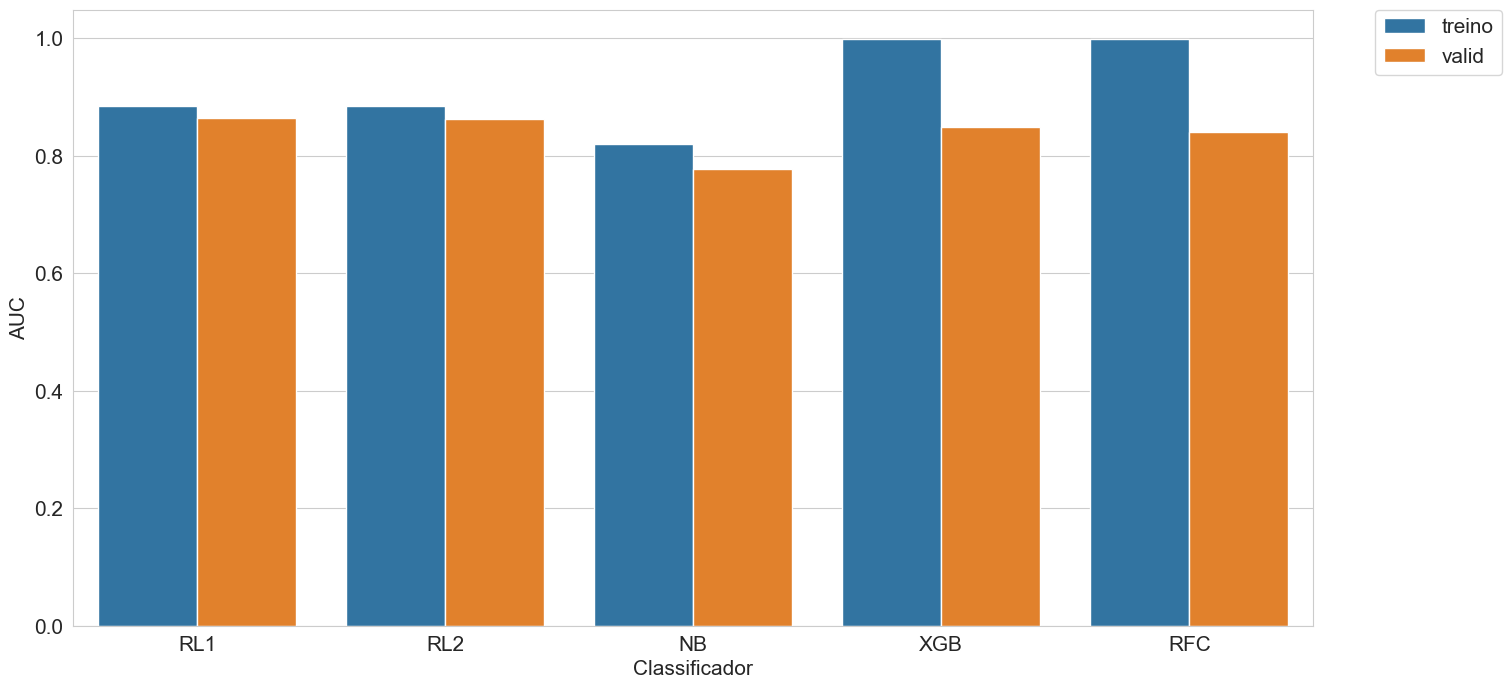

In [252]:
# Construção do Plot
sns.set_style("whitegrid")
plt.figure(figsize = (16, 8))

# Gráfico de barras
ax = sns.barplot(x = 'classificador', y = 'auc', hue = 'data_set', data = df_results)
ax.set_xlabel('Classificador', fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize = 15)

# Legenda
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0., fontsize = 15)

## Otimização de Hiperparâmetros e Validação Cruzada

In [255]:
from sklearn.model_selection import GridSearchCV

# Espaço de busca dos hiperparâmetros
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],  # Tipos de regularização
    'C': [0.01, 0.1, 1, 10, 100],                 # Força da regularização (inverso)
    'solver': ['lbfgs', 'liblinear', 'saga'],     # Solvers compatíveis
    'max_iter': [500, 1000, 2000]                 # Iterações para convergência
}

# Cria o classificador
logreg = LogisticRegression(random_state=42)

# Configura o GridSearchCV
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=2,
    n_jobs=-1
)

# Treina o modelo com validação cruzada e busca pelos melhores hiperparâmetros
modelo_log_otimizado = grid_search.fit(X_treino_final, y_treino)

# Melhores hiperparâmetros encontrados
print('Melhores hiperparâmetros:', modelo_log_otimizado.best_params_)

# Previsões de probabilidade
y_train_preds = modelo_log_otimizado.predict_proba(X_treino_final)[:, 1]
y_valid_preds = modelo_log_otimizado.predict_proba(X_valid_final)[:, 1]

print('\nModelo de Regressão Logística com Otimização de Hiperparâmetros:\n')

print('Treinamento:\n')
log_train_auc, log_train_accuracy, log_train_recall, log_train_precision, log_train_specificity = print_report(
    y_treino, y_train_preds, thresh
)

print('\nValidação:\n')
log_valid_auc, log_valid_accuracy, log_valid_recall, log_valid_precision, log_valid_specificity = print_report(
    y_valid, y_valid_preds, thresh
)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Melhores hiperparâmetros: {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}

Modelo de Regressão Logística com Otimização de Hiperparâmetros:

Treinamento:

AUC:0.888
Acurácia:0.806
Recall:0.771
Precisão:0.829
Especificidade:0.841
 

Validação:

AUC:0.865
Acurácia:0.788
Recall:0.767
Precisão:0.595
Especificidade:0.796
 


## Conclusão: Qual modelo usar?

**Modelo de Regressão Logística "Vanilla"**:

Validação:

- AUC:0.849
- Acurácia:0.772
- Recall:0.688
- Precisão:0.610
- Especificidade:0.808

**Modelo de Regressão Logística Otimizado**:

Validação:

- AUC:0.857
- Acurácia:0.775
- Recall:0.688
- Precisão:0.615
- Especificidade:0.813


**Decisão**: Usa-se o modelo de Regressão Logística sem otimização de hiperparâmetros pois é mais simples e requer menos tempo de treinamento.

### Salvando o Melhor Modelo

In [259]:
# Grava o modelo em disco
pickle.dump(modelo_v1, open('melhor_modelo.pkl', 'wb'), protocol = 4)